In [39]:
!pwd
import os
os.chdir('..')
!pwd

/Users/miguelmartins/Projects/hybrid-hmm
/Users/miguelmartins/Projects


In [40]:
import numpy as np
import tensorflow as tf
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from utility_functions.metrics import schmidt_metrics

In [41]:
!pwd

/Users/miguelmartins/Projects


In [42]:
!ls results/hybrid/circor/hmm_mmi_circor_envelops_nnonly_adam1e3/2022-09-07_15:29:09


ls: results/hybrid/circor/hmm_mmi_circor_envelops_nnonly_adam1e3/2022-09-07_15:29:09: No such file or directory


In [43]:
def schmidt_fold(gt, _h_vit):
    n_folds = gt.shape[0]
    mean_fold_ppv = []
    mean_fold_sensitivity = []
    for fold in range(n_folds):
        n_sounds = gt[fold].shape[0]
        ppv, sensitivity = [], []
        for sound in range(n_sounds):
            ppv_, sensitivity_ = schmidt_metrics(gt[fold][sound], _h_vit[fold][sound])
            ppv.append(ppv_)
            sensitivity.append(sensitivity_)
        mean_fold_ppv.append(np.mean(ppv))
        mean_fold_sensitivity.append(np.mean(sensitivity))

    return mean_fold_ppv, mean_fold_sensitivity

In [44]:
def read_results(path: str):
    gt = sio.loadmat(path + '/ground_truth.mat', squeeze_me=True)['ground_truth']
    cnn = sio.loadmat(path + '/out_seq.mat', squeeze_me=True)['out_seq']
    vit = sio.loadmat(path + '/viterbi.mat', squeeze_me=True)['viterbi']
    return gt, cnn, vit

In [45]:
def get_accuracy(gt, cnn, n_folds=10):
    acc_folds = []
    for fold in range(n_folds):
        accuracy = []
        for sound in range(len(gt[fold])):
            try:
                accuracy.append(accuracy_score(gt[fold][sound], cnn[fold][sound]))
            except:
                print("fold", fold, "sound", sound, " ", gt[fold][sound].shape, cnn[fold][sound].shape)
                pass
        acc_folds.append(np.mean(accuracy))
    return acc_folds

In [46]:

def metrics_model(path: str):
    gt, cnn, vit = read_results(path)
    accuracy = get_accuracy(gt, vit)
    ppv, sensitivity = schmidt_fold(gt, vit)
    return accuracy, ppv, sensitivity

In [10]:
!ls 


circor_hybrid_cle_env = metrics_model('results/hybrid/circor/hmm_completelikelihood_circor_envelops_joint/2022-07-14_21:38:18')
circor_unet_cre_env = metrics_model('results/unet/circor/unet/2022-06-20_10_40_26')
circor_hybrid_1epoch = metrics_model('results/hybrid/circor/hmm_completelikelihood_circor_envelops_joint/2022-07-19_17:09:36')
# v não é nn only. é nn + HMM com SGD com learning rate 1e-4
circor_hybrid_env_cl_nn_only = metrics_model('results/hybrid/circor/hmm_completelikelihood_circor_envelops_joint/2022-07-22_18:36:22')
circor_nn_only_env_cl = metrics_model('results/hybrid/circor/hmm_completelikelihood_circor_envelops_nnonly/2022-07-31_16:50:27')

circor_nn_only_env_mmi_1e4 = metrics_model('results/hybrid/circor/hmm_mmi_circor_envelops_nnonly_adam1e4/2022-08-22_13:56:23')
circor_nn_only_env_mmi_1e3 = metrics_model('results/hybrid/circor/hmm_mmi_circor_envelops_nnonly_adam1e3/2022-09-07_15:29:09')

circor_fernando = metrics_model('results/fernando/circor/fernando_CE_physio16_mfcc_joint/2022-09-16_15_46_30')

README.md                       notebook
checkpoint                      notebooks
circor_100_nogaps_50hz.npy      random_init.data-00000-of-00001
circor_100_raw_50hz.npy         random_init.index
circor_springer_np.npy          requirements.txt.py
custom_train_functions          results
data_processing                 test.txt
datasets                        tests
loss_functions                  train_scripts
models                          utility_functions


In [11]:
!ls results/fernando/circor/fernando_CE_physio16_mfcc_joint/2022-09-16_15_46_30

ground_truth.mat     test_indexes.mat     viterbi.mat
out_seq.mat          train_indexes.mat    weights_fold0.hdf5
p_states.mat         trans_mat.mat        weights_fold1.hdf5
p_states_fold_0.npy  trans_mat_fold_0.npy weights_fold2.hdf5
p_states_fold_1.npy  trans_mat_fold_1.npy weights_fold3.hdf5
p_states_fold_2.npy  trans_mat_fold_2.npy weights_fold4.hdf5
p_states_fold_3.npy  trans_mat_fold_3.npy weights_fold5.hdf5
p_states_fold_4.npy  trans_mat_fold_4.npy weights_fold6.hdf5
p_states_fold_5.npy  trans_mat_fold_5.npy weights_fold7.hdf5
p_states_fold_6.npy  trans_mat_fold_6.npy weights_fold8.hdf5
p_states_fold_7.npy  trans_mat_fold_7.npy weights_fold9.hdf5
p_states_fold_8.npy  trans_mat_fold_8.npy
p_states_fold_9.npy  trans_mat_fold_9.npy


In [12]:
gt, cnn, vit = read_results('results/hybrid/circor/hmm_completelikelihood_circor_envelops_joint/2022-07-14_21:38:18')

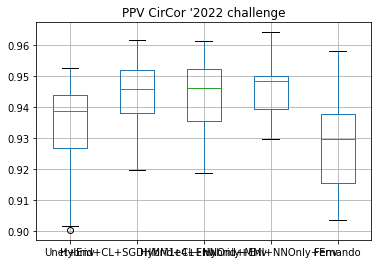

In [13]:
df = pd.DataFrame({
    'Unet+Env': circor_unet_cre_env[1],
    'Hybrid+CL+SGDHMM1e4+Env': circor_hybrid_env_cl_nn_only[1],
    'Hybrid+CL+NNOnly+Env': circor_nn_only_env_cl[1],
    'Hybrid+MMI+NNOnly+Env': circor_nn_only_env_mmi_1e4[1],
    'Fernando': circor_fernando[1]
                   })

boxplot = df.boxplot(column=list(df.keys()), figsize=(30,20))
plt.title('PPV CirCor \'2022 challenge')
plt.show()

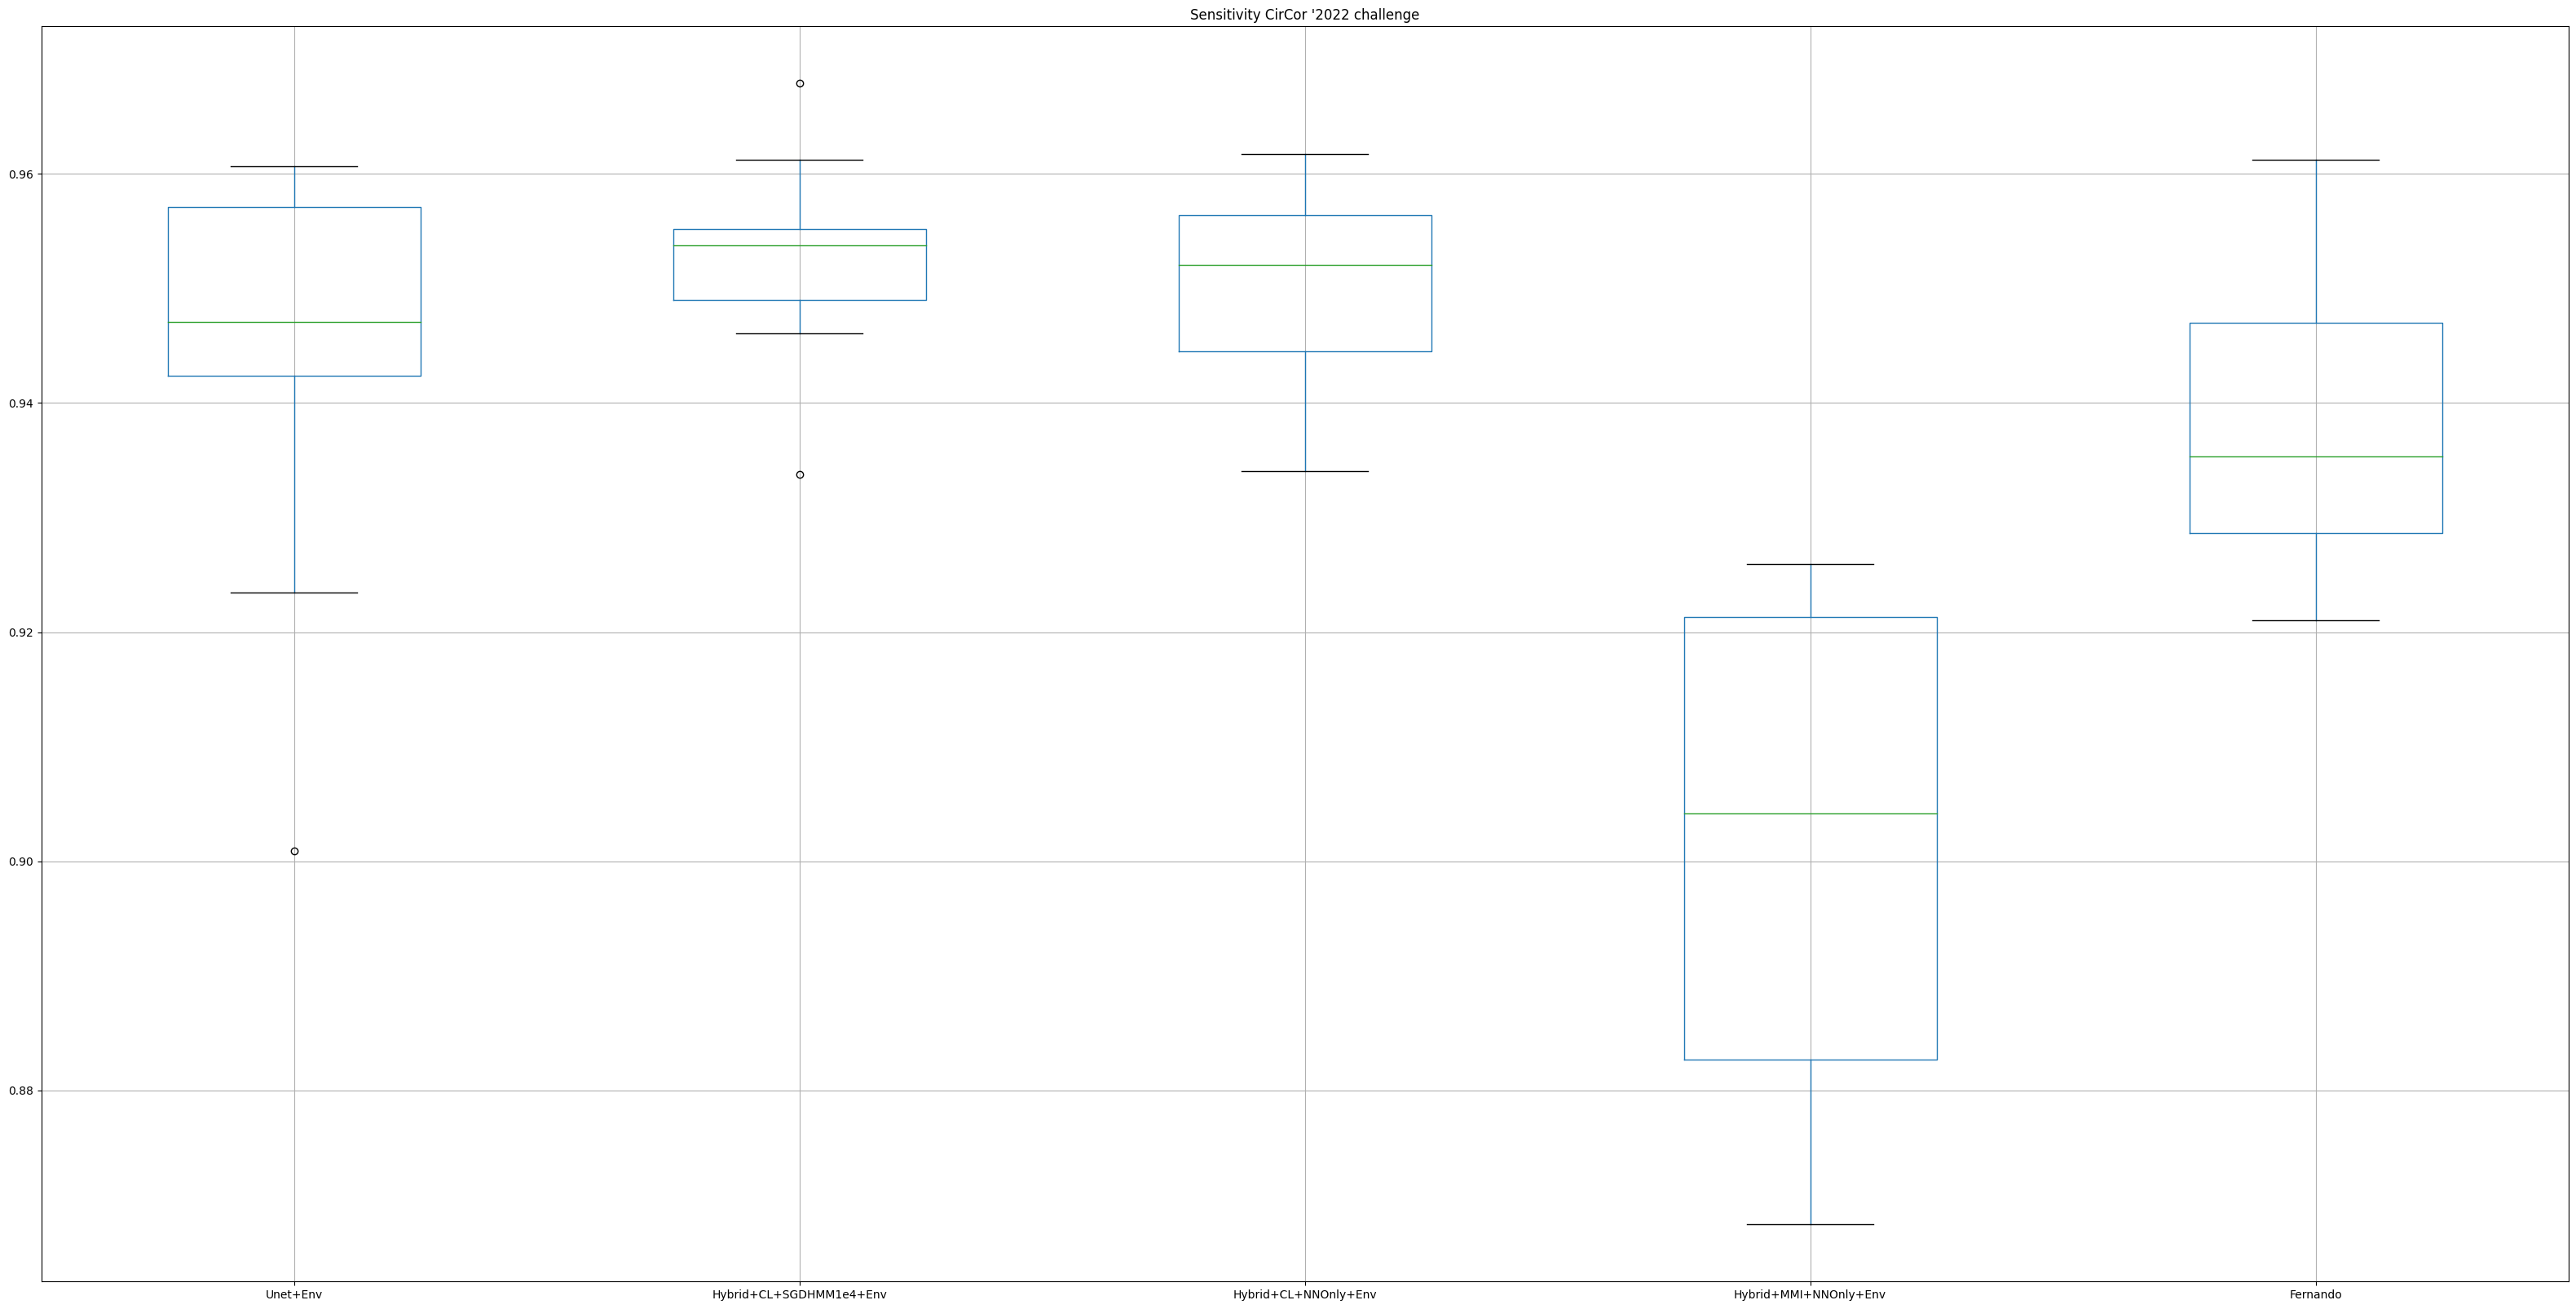

In [14]:
df = pd.DataFrame({
    'Unet+Env': circor_unet_cre_env[2],
    'Hybrid+CL+SGDHMM1e4+Env': circor_hybrid_env_cl_nn_only[2],
    'Hybrid+CL+NNOnly+Env': circor_nn_only_env_cl[2],
    'Hybrid+MMI+NNOnly+Env': circor_nn_only_env_mmi_1e3[2],
    'Fernando': circor_fernando[2]
    
                   })

boxplot = df.boxplot(column=list(df.keys()), figsize=(40,20))
plt.title('Sensitivity CirCor \'2022 challenge')
plt.show()

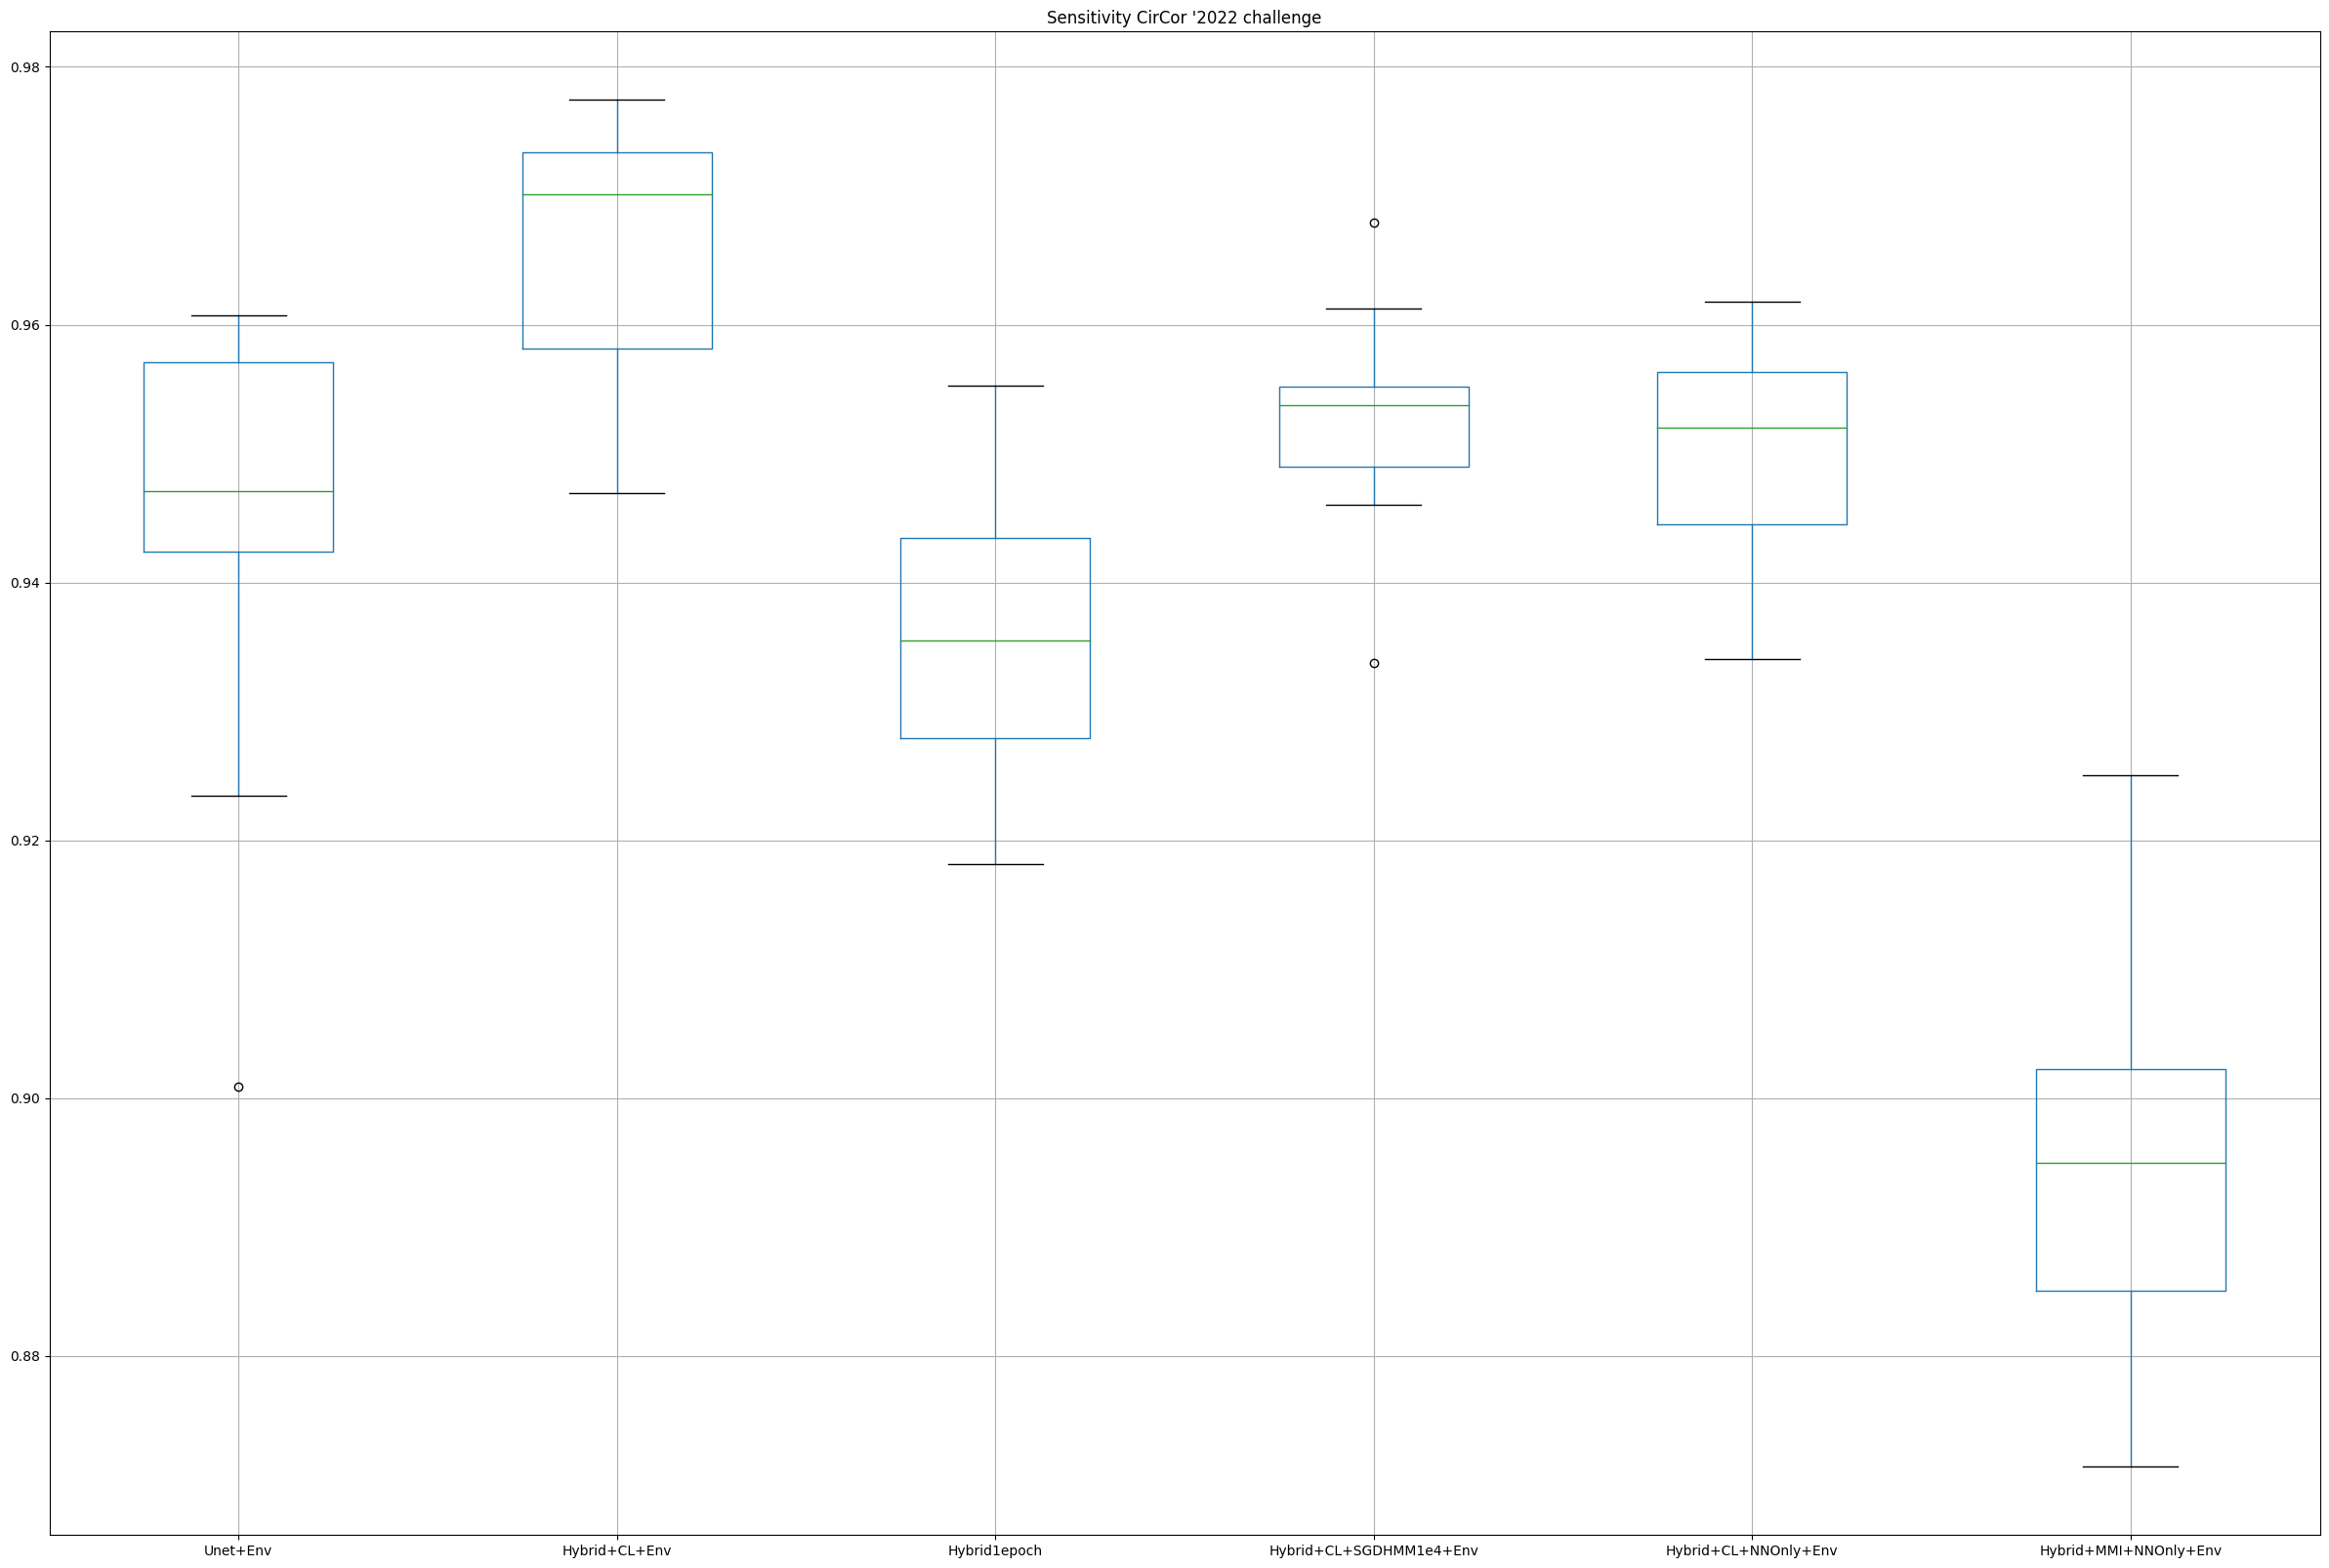

In [14]:
df = pd.DataFrame({
    'Unet+Env': circor_unet_cre_env[2],
    'Hybrid+CL+Env': circor_hybrid_cle_env[2],
    'Hybrid1epoch': circor_hybrid_1epoch[2],
    'Hybrid+CL+SGDHMM1e4+Env': circor_hybrid_env_cl_nn_only[2],
    'Hybrid+CL+NNOnly+Env': circor_nn_only_env_cl[2],
    'Hybrid+MMI+NNOnly+Env': circor_nn_only_env_mmi_1e4[2],
    
                   })

boxplot = df.boxplot(column=list(df.keys()), figsize=(30,20))
plt.title('Sensitivity CirCor \'2022 challenge')
plt.show()



In [16]:
 circor_unet_cre_env[2], circor_hybrid_env_cl_nn_only[2]

([0.9464495966775881,
  0.9009222577219589,
  0.9570922911019096,
  0.9579092261157683,
  0.9413642090046082,
  0.9477610025518295,
  0.9454448691338878,
  0.9570754823843536,
  0.9234297227429643,
  0.9606859235052334],
 [0.9531751293995137,
  0.9544647386416951,
  0.9554442936816346,
  0.9543837076532243,
  0.9460616403141231,
  0.9492521142391139,
  0.9489077645518325,
  0.9612265530178732,
  0.9337805409365841,
  0.9678918015295088])

## Rerun Physionet'16
Should results suck on physionet, try mmi / CL Adam 1e-4

In [12]:
ph16_crosse_unet_env = metrics_model('results/unet/unet/2022-02-26_07_49_39')
ph16_fernando_CE_mfcc = metrics_model('results/rerun/fernando/fernando_CE_physio16_mfcc_joint/2022-09-17_07_52_13/')
ph16_hmm_nnonly_mmi_env = metrics_model('results/rerun/hybrid/hmm_nnonly_mmi_env_physio16/2022-09-17_10_08_14')
ph16_hmm_hybrid_mmi_env = metrics_model('results/rerun/hybrid/hmm_hybrid_mmi_env_physio16/2022-09-16_15_46_30')
ph16_hmm_nnonly_cl_env = metrics_model('results/rerun/hybrid/hmm_nnonly_cl_env_physio16/2022-09-18_09_38_31')
ph_16_hmm_hybird_cl_env = metrics_model('results/rerun/hybrid/hmm_hybrid_cl_env_physio16/2022-09-19_10_57_50')
ph_16_hmm_nnonly_cl_mfcc = metrics_model('results/rerun/hybrid/mfcc/2022-09-20_08_01_55')
ph_16_hmm_nnonly_cl_psd = metrics_model('results/rerun/hybrid/psd/hmm_nnonly_cl_psd_ph16/2022-09-26_11_51_19')

In [60]:
!ls results/rerun/hybrid/hmm_cl_ph16_circor/2022-09-29_10_51_18



ground_truth.mat  p_states.mat      train_indexes.mat viterbi.mat
out_seq.mat       test_indexes.mat  trans_mat.mat


Text(0.5, 1.0, "PPV Physionet'2016 challenge")

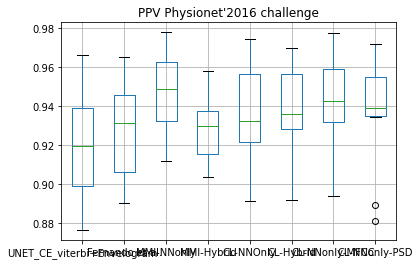

In [13]:
df = pd.DataFrame({'UNET_CE_viterbi+Envelogram': ph16_crosse_unet_env[1],
                   'Fernando et al.': ph16_fernando_CE_mfcc[1],
                   'MMI-NNonly': ph16_hmm_nnonly_mmi_env[1], 
                   'MMI-Hybrid': ph16_hmm_hybrid_mmi_env[1],
                   'CL-NNOnly': ph16_hmm_nnonly_cl_env[1],
                   'CL-Hybrid': ph_16_hmm_hybird_cl_env[1],
                   'CL-NNonly-MFCC': ph_16_hmm_nnonly_cl_mfcc[1],
                   'CL-NNonly-PSD': ph_16_hmm_nnonly_cl_psd[1]
                   }) # no grads CL, no grads MMI,  CL envelogram, corrected fernando
boxplot = df.boxplot(column=list(df.keys()), figsize=(30,20))
plt.title('PPV Physionet\'2016 challenge')


Text(0.5, 1.0, "Sensitivity Physionet'2016 challenge")

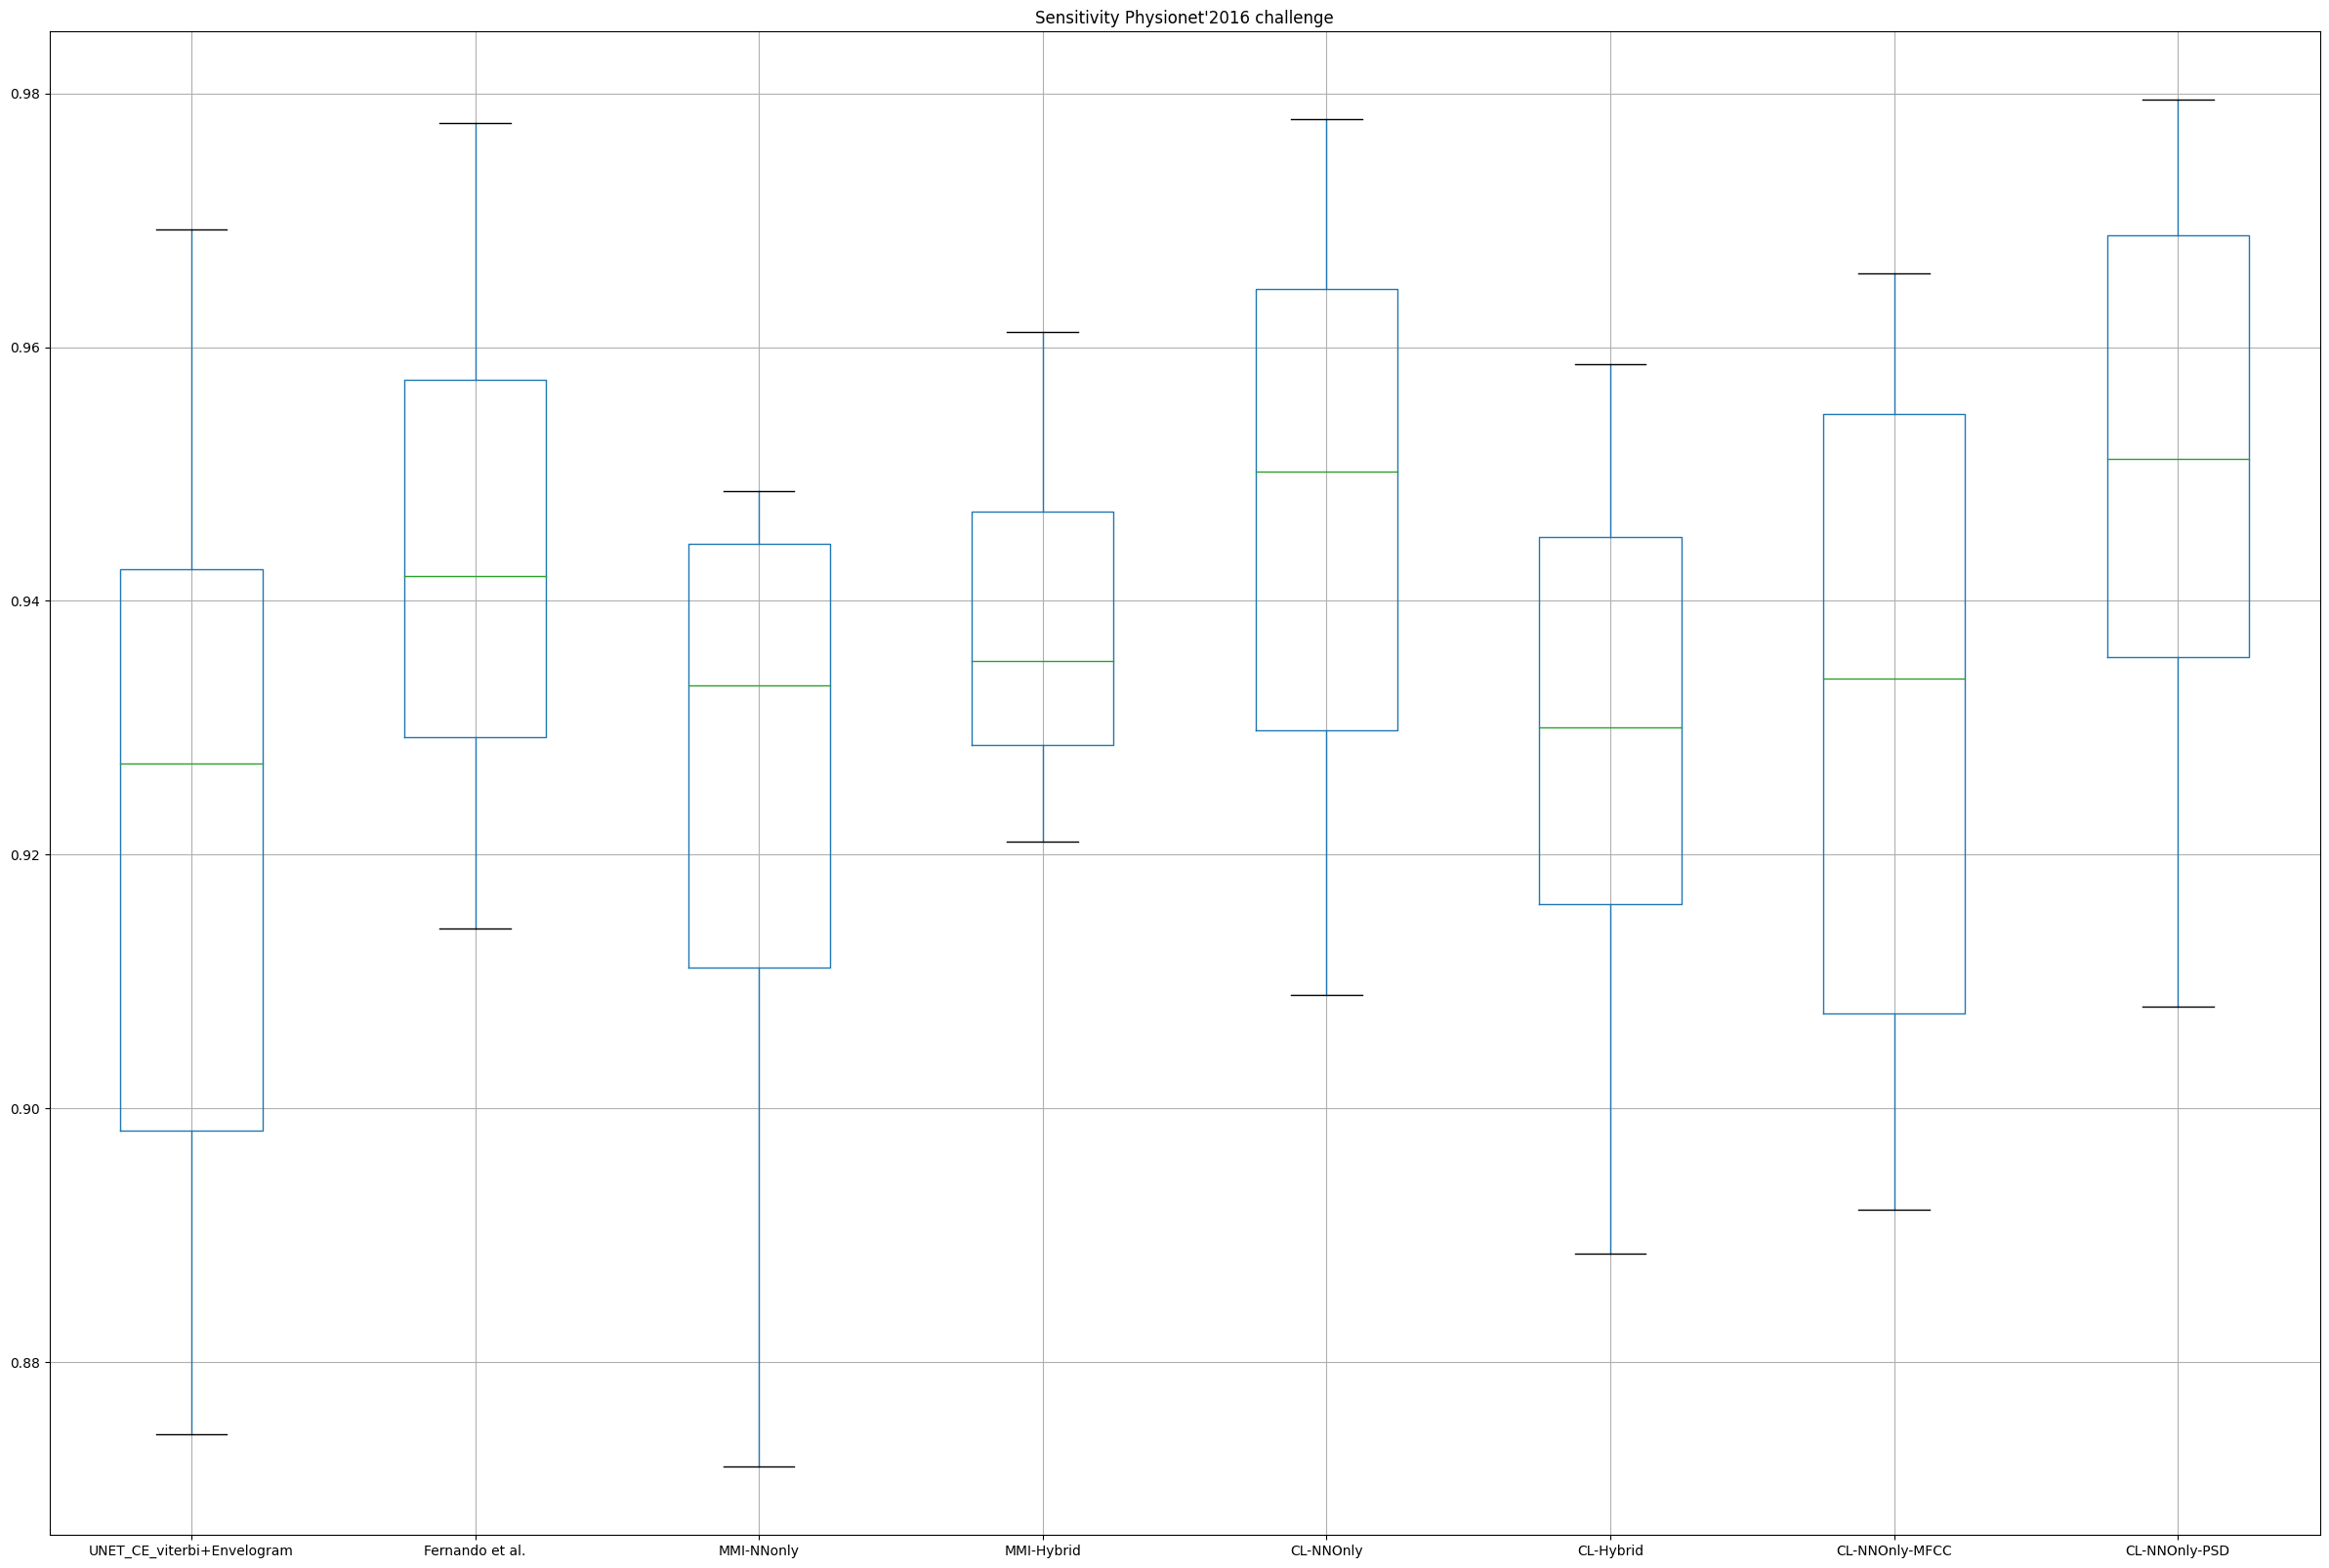

In [14]:
df = pd.DataFrame({'UNET_CE_viterbi+Envelogram': ph16_crosse_unet_env[2],
                   'Fernando et al.': ph16_fernando_CE_mfcc[2],
                   'MMI-NNonly': ph16_hmm_nnonly_mmi_env[2], # run at 1e-3
                   'MMI-Hybrid': ph16_hmm_hybrid_mmi_env[2],
                   'CL-NNOnly': ph16_hmm_nnonly_cl_env[2], # run at 1e-3 maybe try 1e-4,
                   'CL-Hybrid': ph_16_hmm_hybird_cl_env[2],
                   'CL-NNOnly-MFCC': ph_16_hmm_nnonly_cl_mfcc[2],
                   'CL-NNOnly-PSD': ph_16_hmm_nnonly_cl_psd[2]
                   }) # no grads CL, no grads MMI,  CL envelogram, corrected fernando
boxplot = df.boxplot(column=list(df.keys()), figsize=(30,20))
plt.title('Sensitivity Physionet\'2016 challenge')

# Transfer

In [92]:
# unet_ph16_circor = metrics_model('results/rerun/unet/unet_transfer_ph16_circor/2022-09-28_09_38_17')
# unet_ph16_circor = metrics_model('results/rerun/unet/unet_transfer_ph16_circor/2022-09-28_14_45_49')
unet_ph16_circor = metrics_model('results/rerun/unet/unet_transfer_ph16_circor/2022-09-29_14_42_54')
hmm_ph16_circor = metrics_model('results/rerun/hybrid/hmm_cl_ph16_circor/2022-09-29_10_51_18')
fernando_ph16_circor = metrics_model('results/rerun/fernando/fernando_ph16_circor/2022-09-29_11_20_39')
hmm_ft = metrics_model('results/rerun/hybrid/hmm_finetune_ph16_circor/2022-09-30_12:06:09')
ft2 = metrics_model('results/rerun/hybrid/hmm_finetune_ph16_circor/2022-10-01_18:28:45')


FileNotFoundError: [Errno 2] No such file or directory: 'results/rerun/hybrid/hmm_finetune_ph16_circor/2022-10-01_19/40/08/ground_truth.mat'

In [108]:
ft3 = metrics_model('results/rerun/hybrid/hmm_finetune_ph16_circor/2022-10-01_19_40_08')  # 100 1e-3
ft4 = metrics_model('results/rerun/hybrid/hmm_finetune_ph16_circor/2022-10-03_10_11_12') # 50 1e-3
ft5 = metrics_model('results/rerun/hybrid/hmm_finetune_ph16_circor/2022-10-03_14_48_32') # 1 1e-3
ft6 = metrics_model('results/rerun/hybrid/hmm_finetune_ph16_circor/2022-10-03_15_03_07')

In [87]:
# maybe try hmm parameters only`Ωaqwassºsºss



2022-09-30_12:06:09 2022-10-01_18:28:45


In [104]:
!ls results/rerun/hybrid/hmm_finetune_ph16_circor/2022-09-30_12:06:09
sio.loadmat('results/rerun/hybrid/hmm_finetune_ph16_circor/2022-09-30_12:06:09/trans_mat.mat')

ground_truth.mat  p_states.mat      train_indexes.mat viterbi.mat
out_seq.mat       test_indexes.mat  trans_mat.mat


{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Fri Sep 30 13:07:12 2022',
 '__version__': '1.0',
 '__globals__': [],
 'trans_mat': array([[0.85729223, 0.1427078 , 0.        , 0.        ],
        [0.        , 0.90617806, 0.09382191, 0.        ],
        [0.        , 0.        , 0.8002697 , 0.19973034],
        [0.04160044, 0.        , 0.        , 0.95839953]], dtype=float32)}

Text(0.5, 1.0, 'PPV Physionet->Circor')

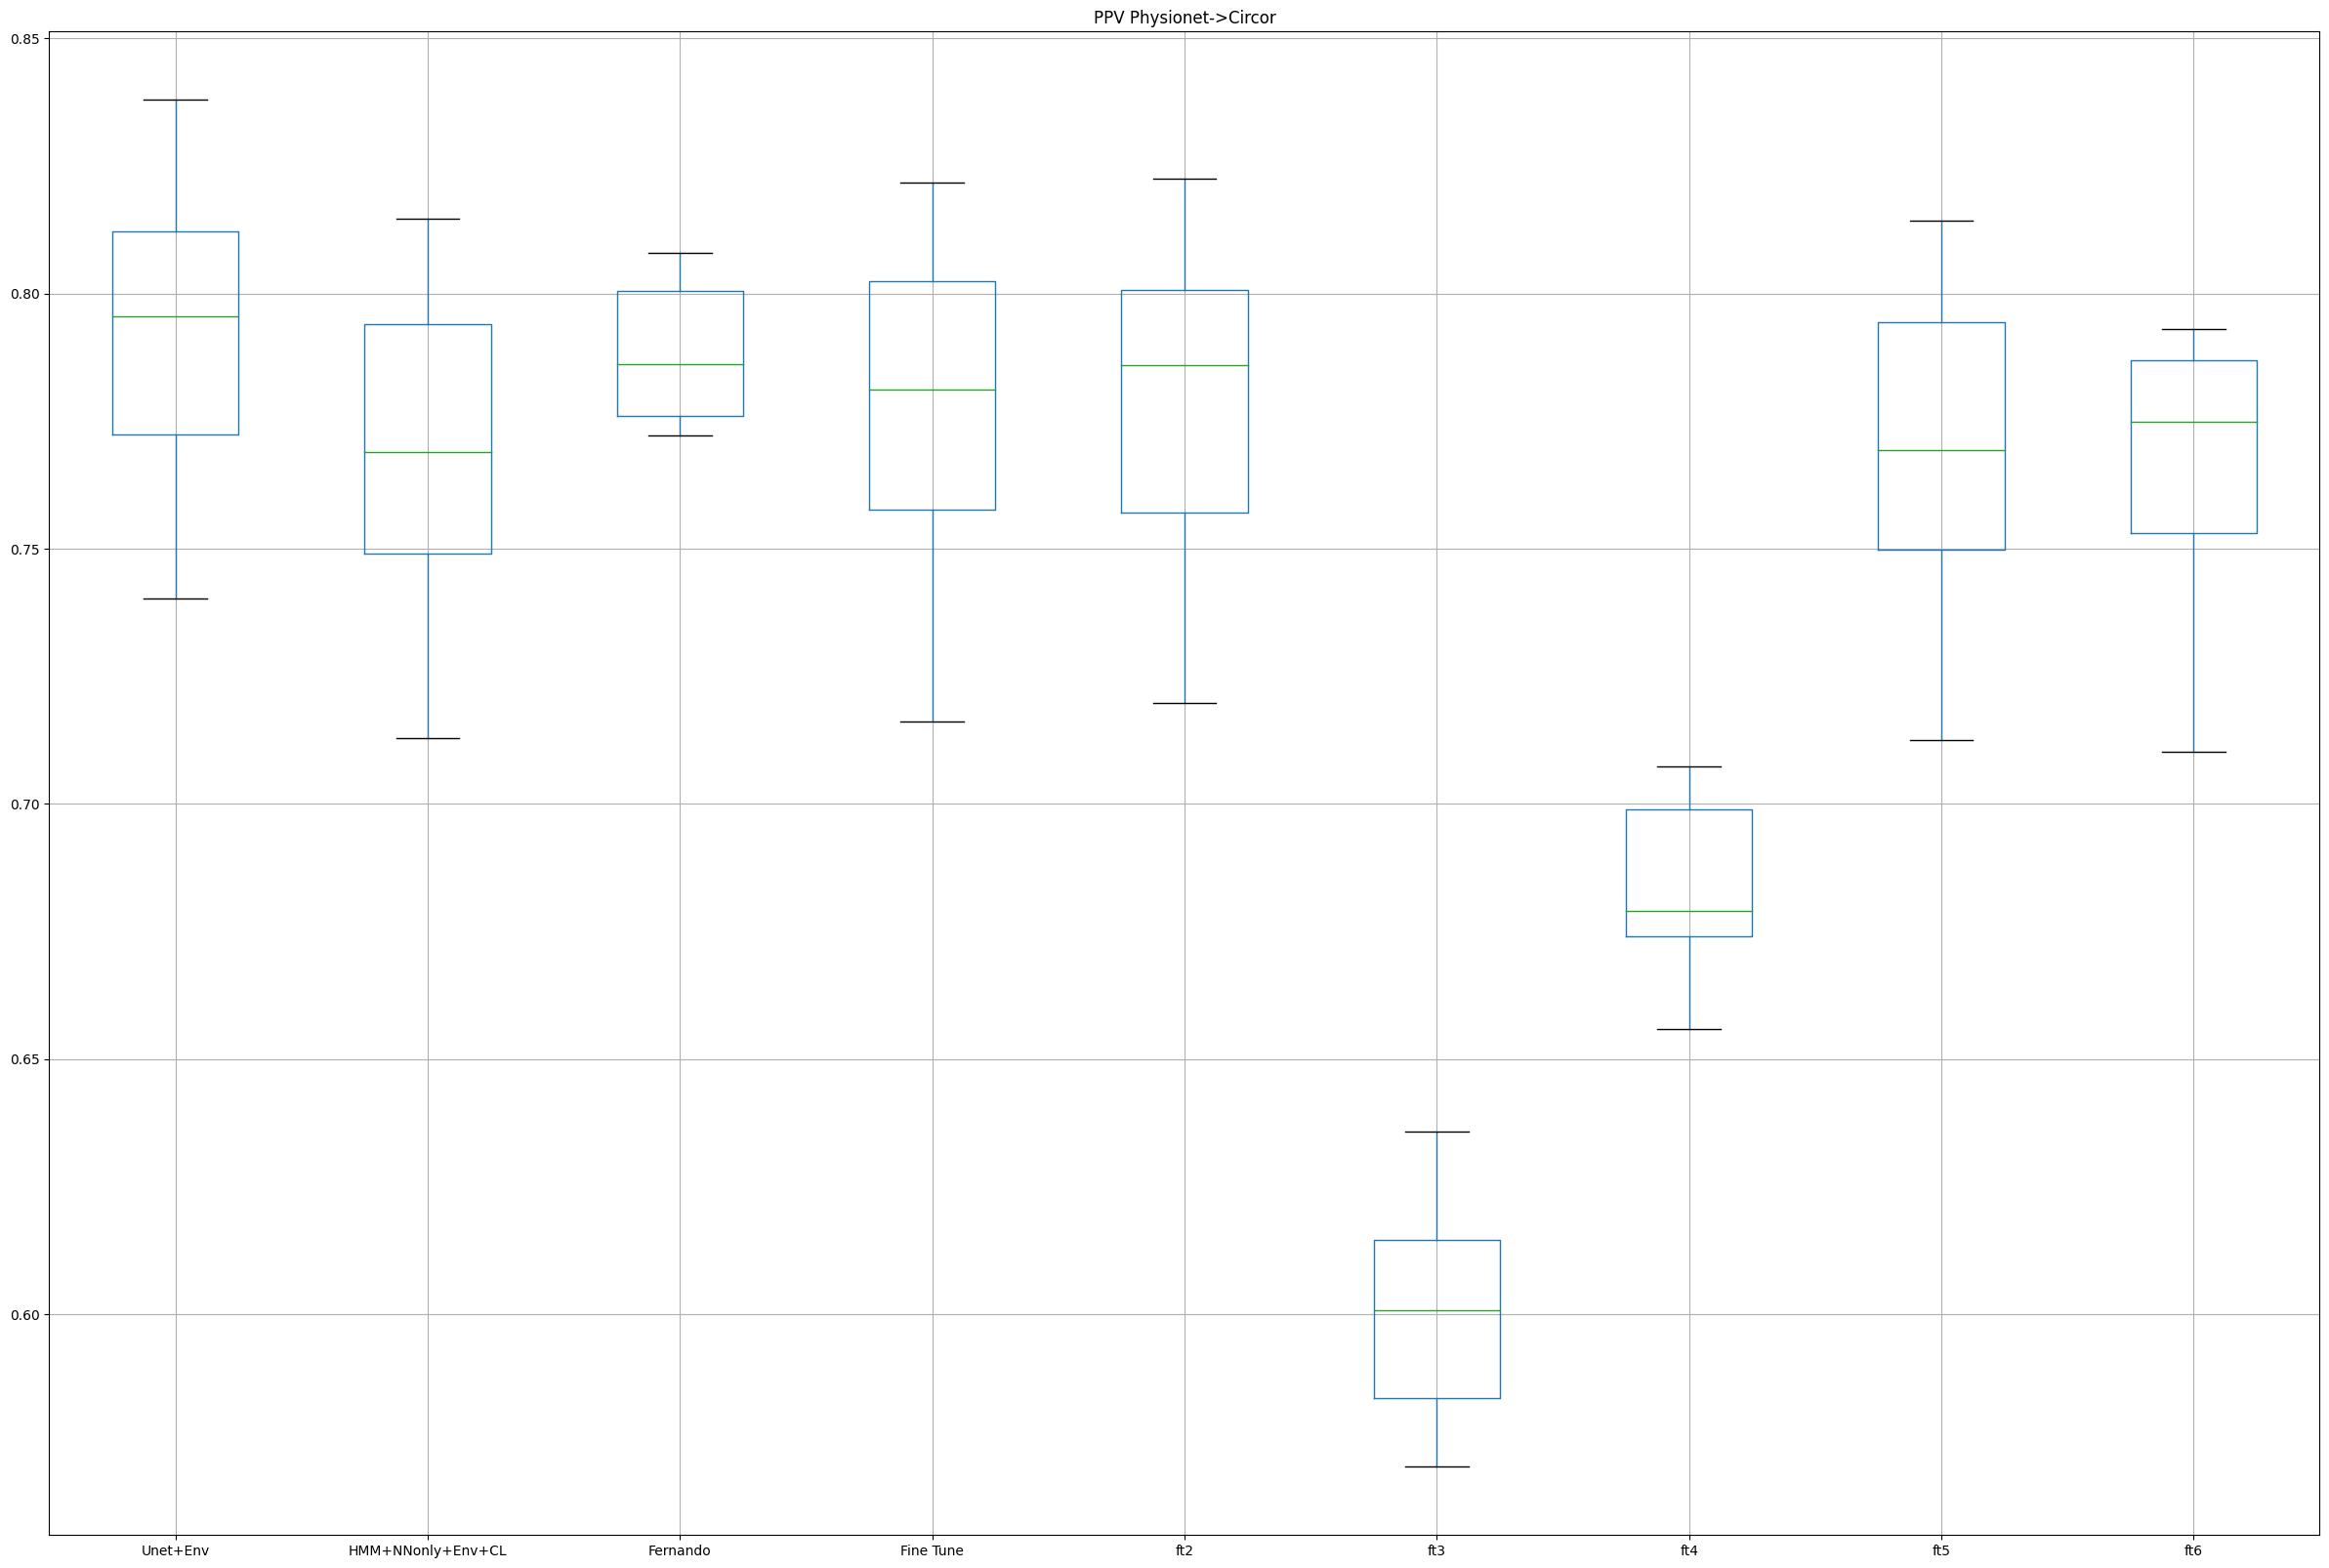

In [109]:
df = pd.DataFrame({'Unet+Env': unet_ph16_circor[1],
                   'HMM+NNonly+Env+CL': hmm_ph16_circor[1],
                   'Fernando': fernando_ph16_circor[1],
                   'Fine Tune': hmm_ft[1],  # 10 epochs 1e-3,
                   'ft2': ft2[1],
                   'ft3': ft3[1],
                   'ft4': ft4[1],
                   'ft5': ft5[1],
                   'ft6': ft6[1]
                   }) # no grads CL, no grads MMI,  CL envelogram, corrected fernando
boxplot = df.boxplot(column=list(df.keys()), figsize=(30,20))
plt.title('PPV Physionet->Circor')


Text(0.5, 1.0, 'Sensivity Physionet->Circor')

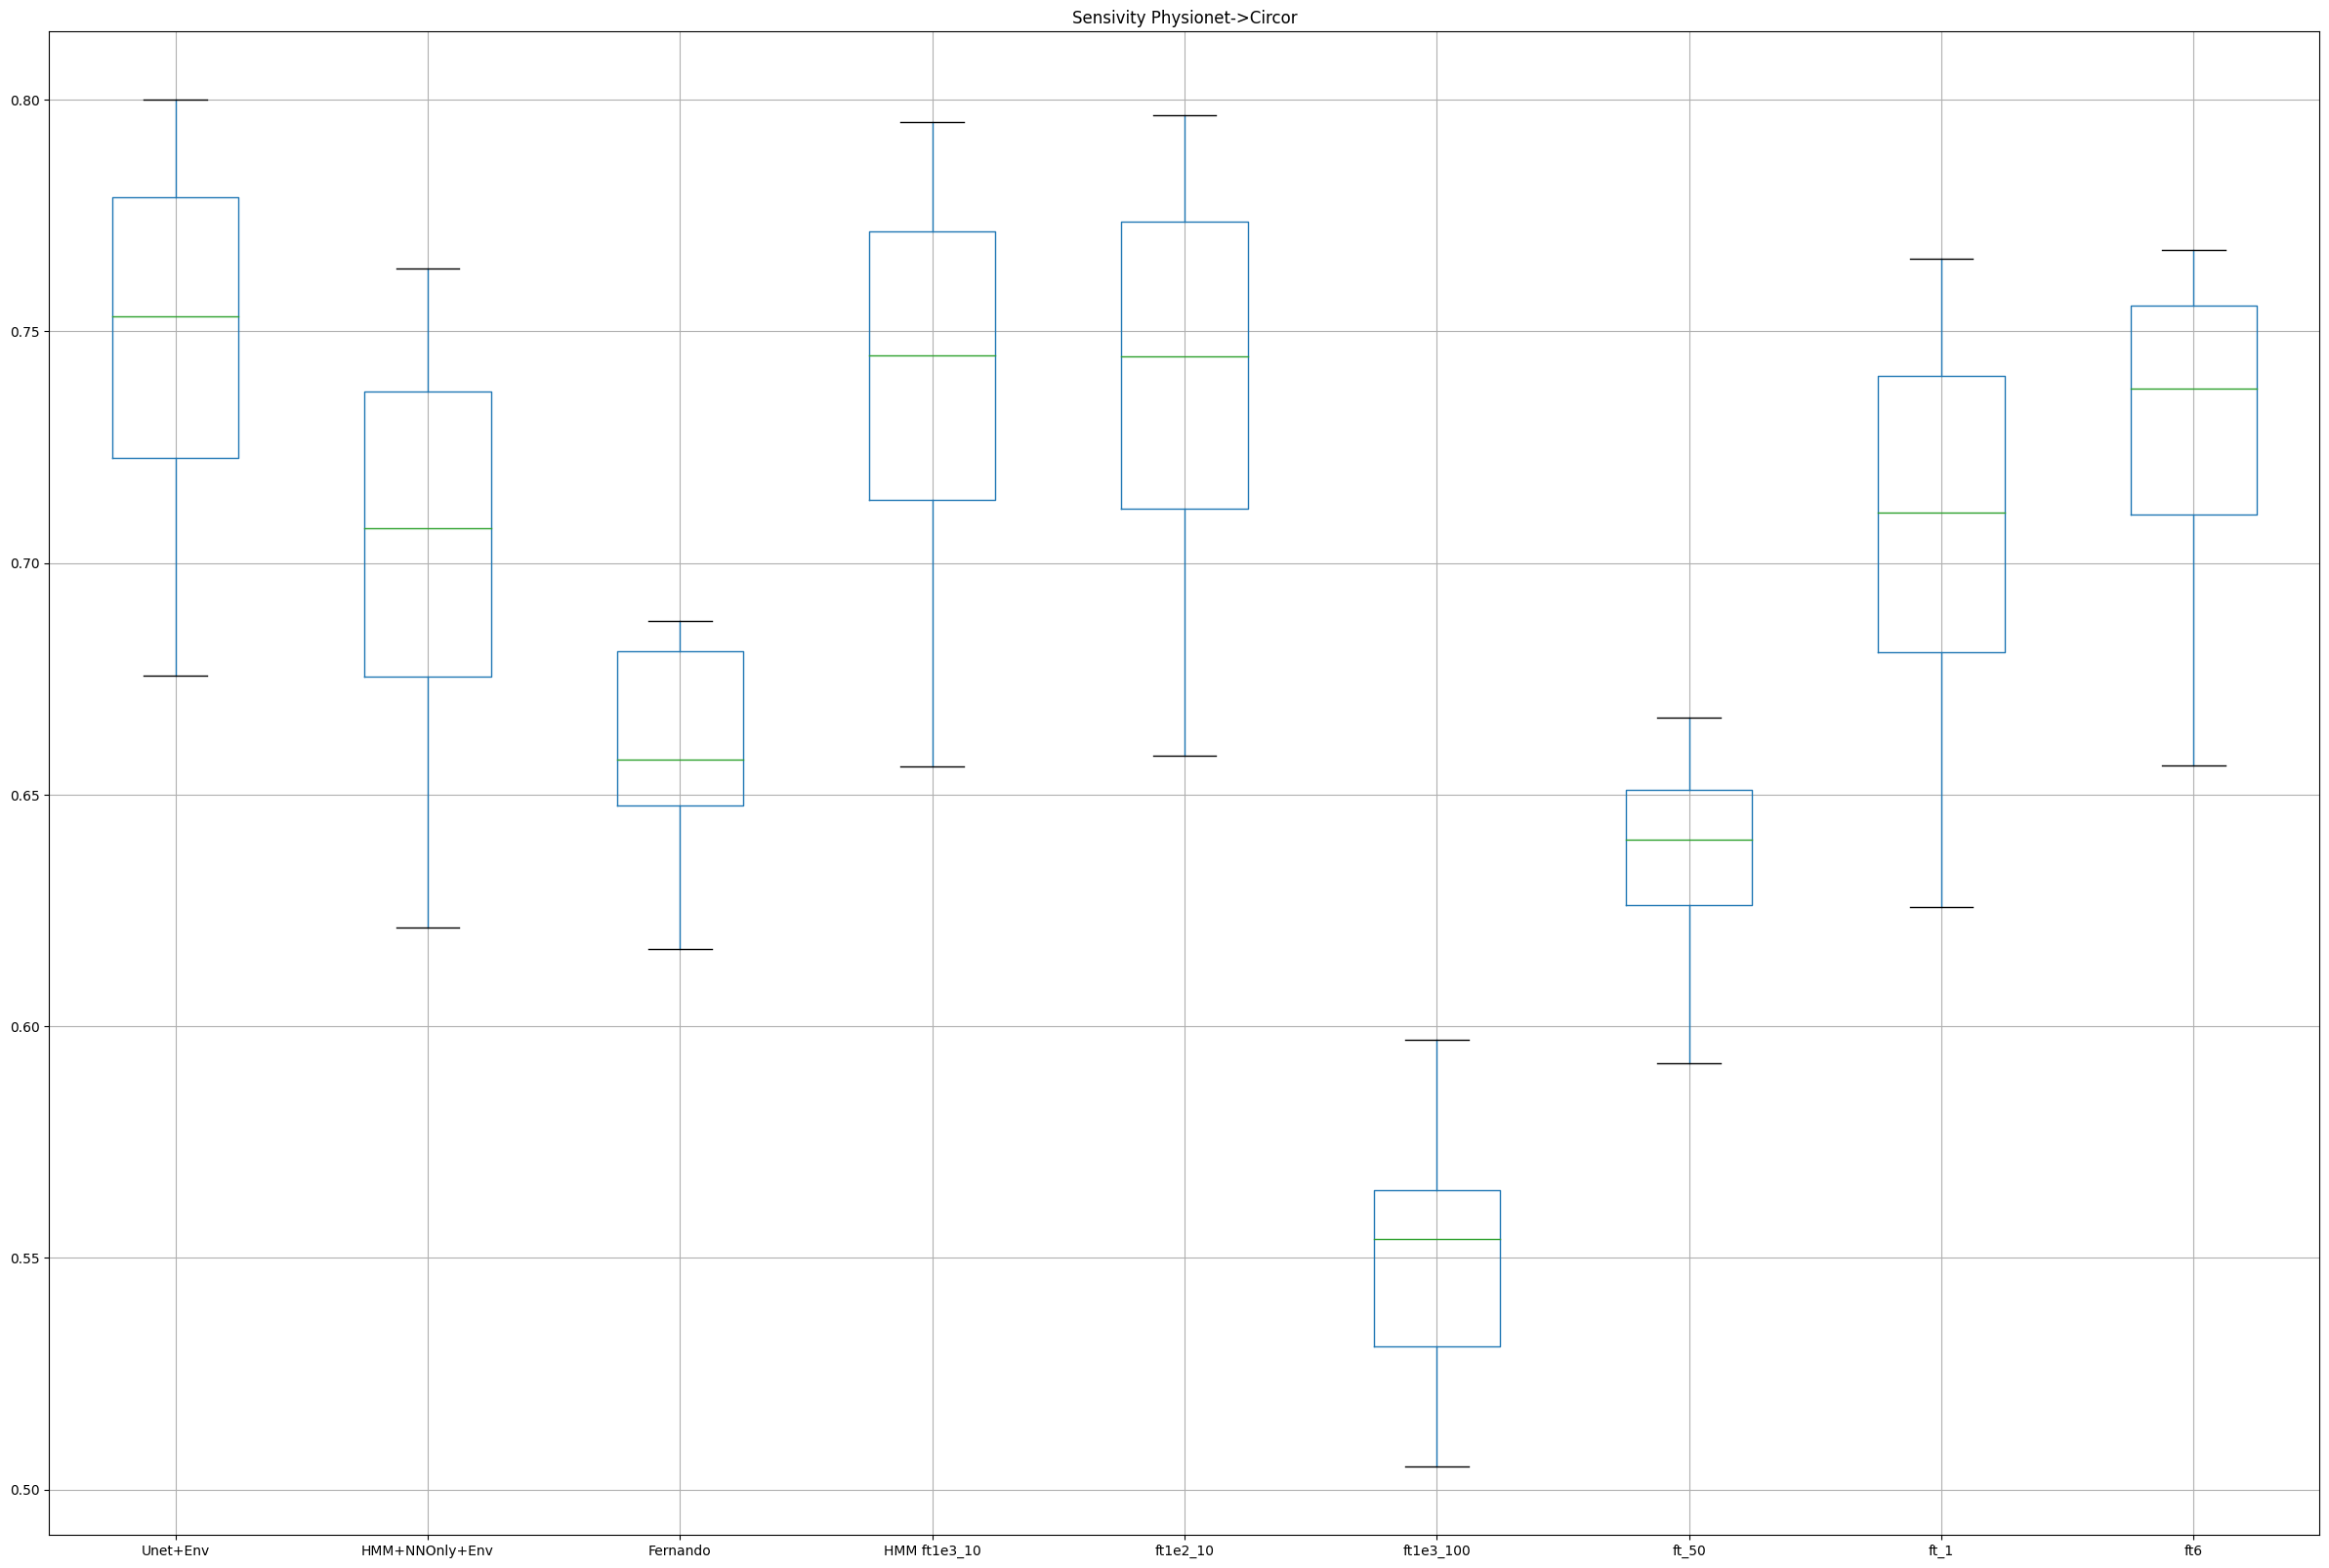

In [110]:
df = pd.DataFrame({'Unet+Env': unet_ph16_circor[2],
                   'HMM+NNOnly+Env': hmm_ph16_circor[2],
                   'Fernando': fernando_ph16_circor[2],
                   'HMM ft1e3_10': hmm_ft[2],
                   'ft1e2_10': ft2[2],
                   'ft1e3_100': ft3[2],
                   'ft_50': ft4[2],
                   'ft_1': ft5[2],
                   'ft6': ft6[2]
                   }) # no grads CL, no grads MMI,  CL envelogram, corrected fernando
boxplot = df.boxplot(column=list(df.keys()), figsize=(30,20))
plt.title('Sensivity Physionet->Circor')

In [318]:
np.std(ft2[1])

0.030508732643827613

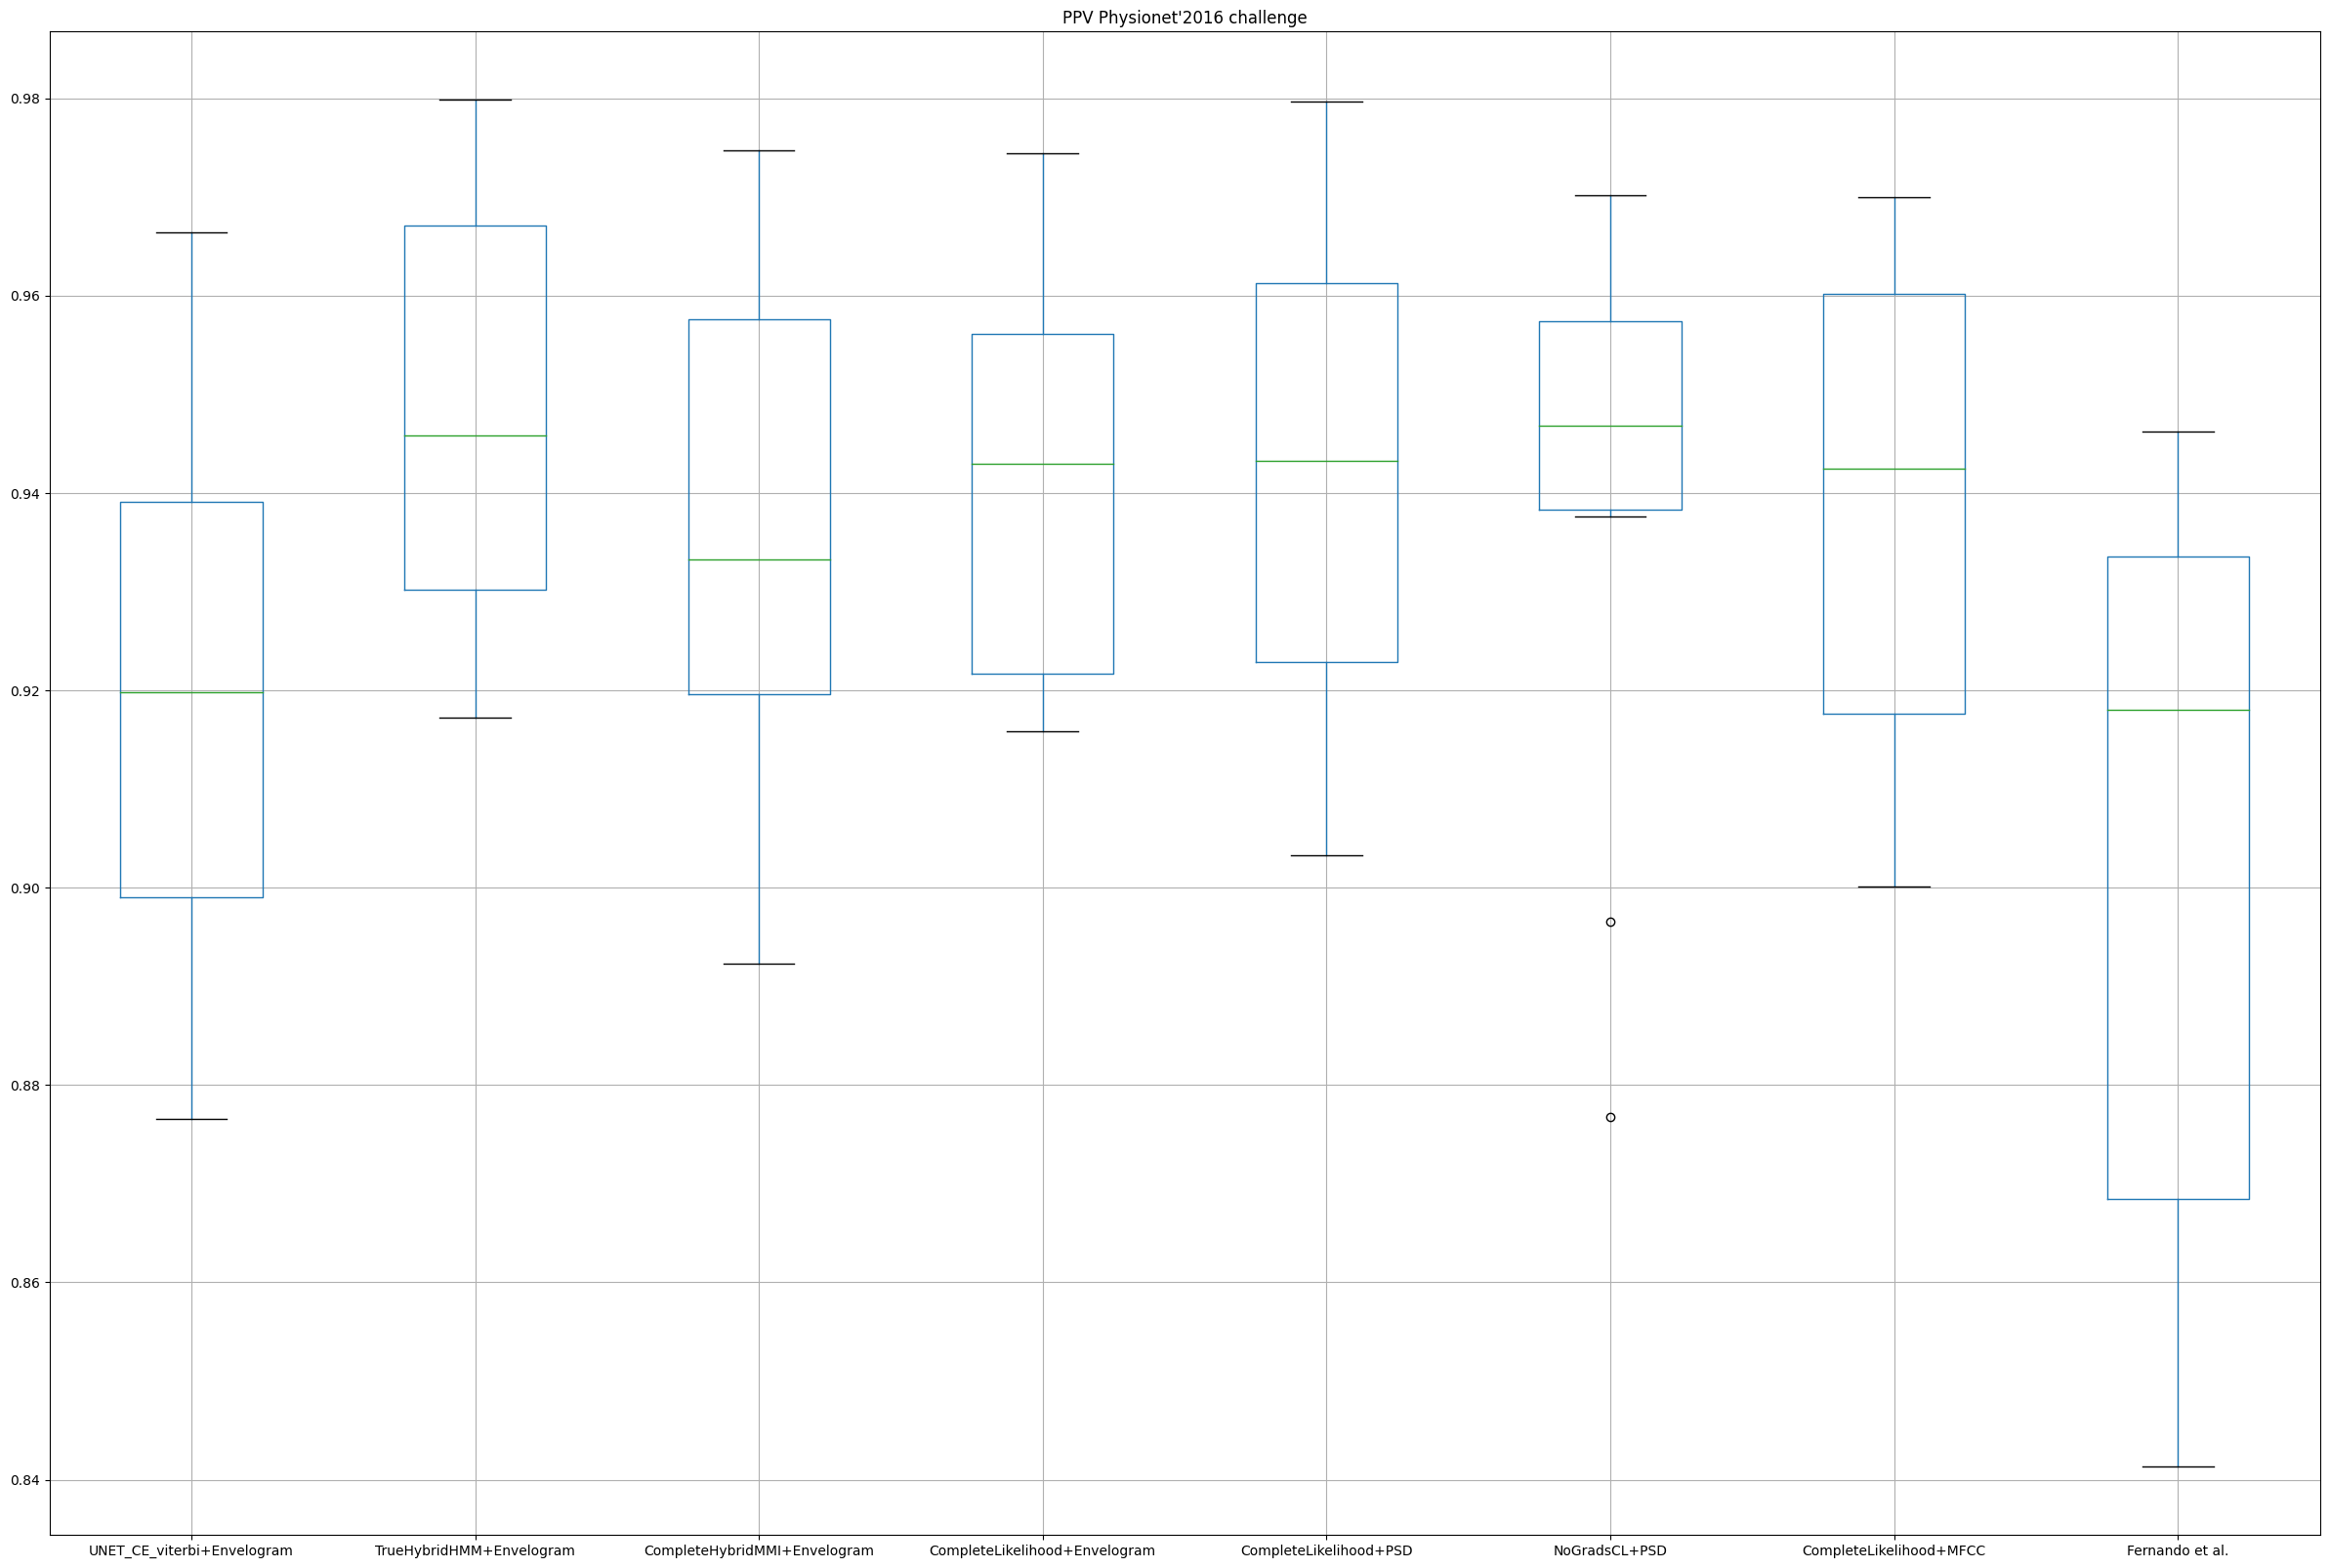

In [33]:
df = pd.DataFrame({'UNET_CE_viterbi+Envelogram': ph16_crosse_unet_env[1],
                   'TrueHybridHMM+Envelogram': ph16_true_hybrid_cnn_env[1],
                   'CompleteHybridMMI+Envelogram': ph16_completemmi_hybrid_cnn_env[1],
                   'CompleteLikelihood+Envelogram':ph16_completelikelihood_hybrid_cnn_env[1],
                   # 'NoGradsCL+Envelogram': ph16_completelikelihood_nograds_cnn_env[0], 
                   'CompleteLikelihood+PSD': ph16_completelikelihood_hybrid_cnn_psd[1],
                   'NoGradsCL+PSD': ph16_completelikelihood_cnngrads_psd[1],
                   'CompleteLikelihood+MFCC': ph16_completelikelihood_hybrid_cnn_mfcc[1],
                   'Fernando et al.': ph16_fernado_mfcc_joint[1],
                   }) # no grads CL, no grads MMI,  CL envelogram, corrected fernando
    
# fine tune best HMM
# transfer u-net, fernando and springer

boxplot = df.boxplot(column=list(df.keys()), figsize=(30,20))
plt.title('PPV Physionet\'2016 challenge')
plt.show()

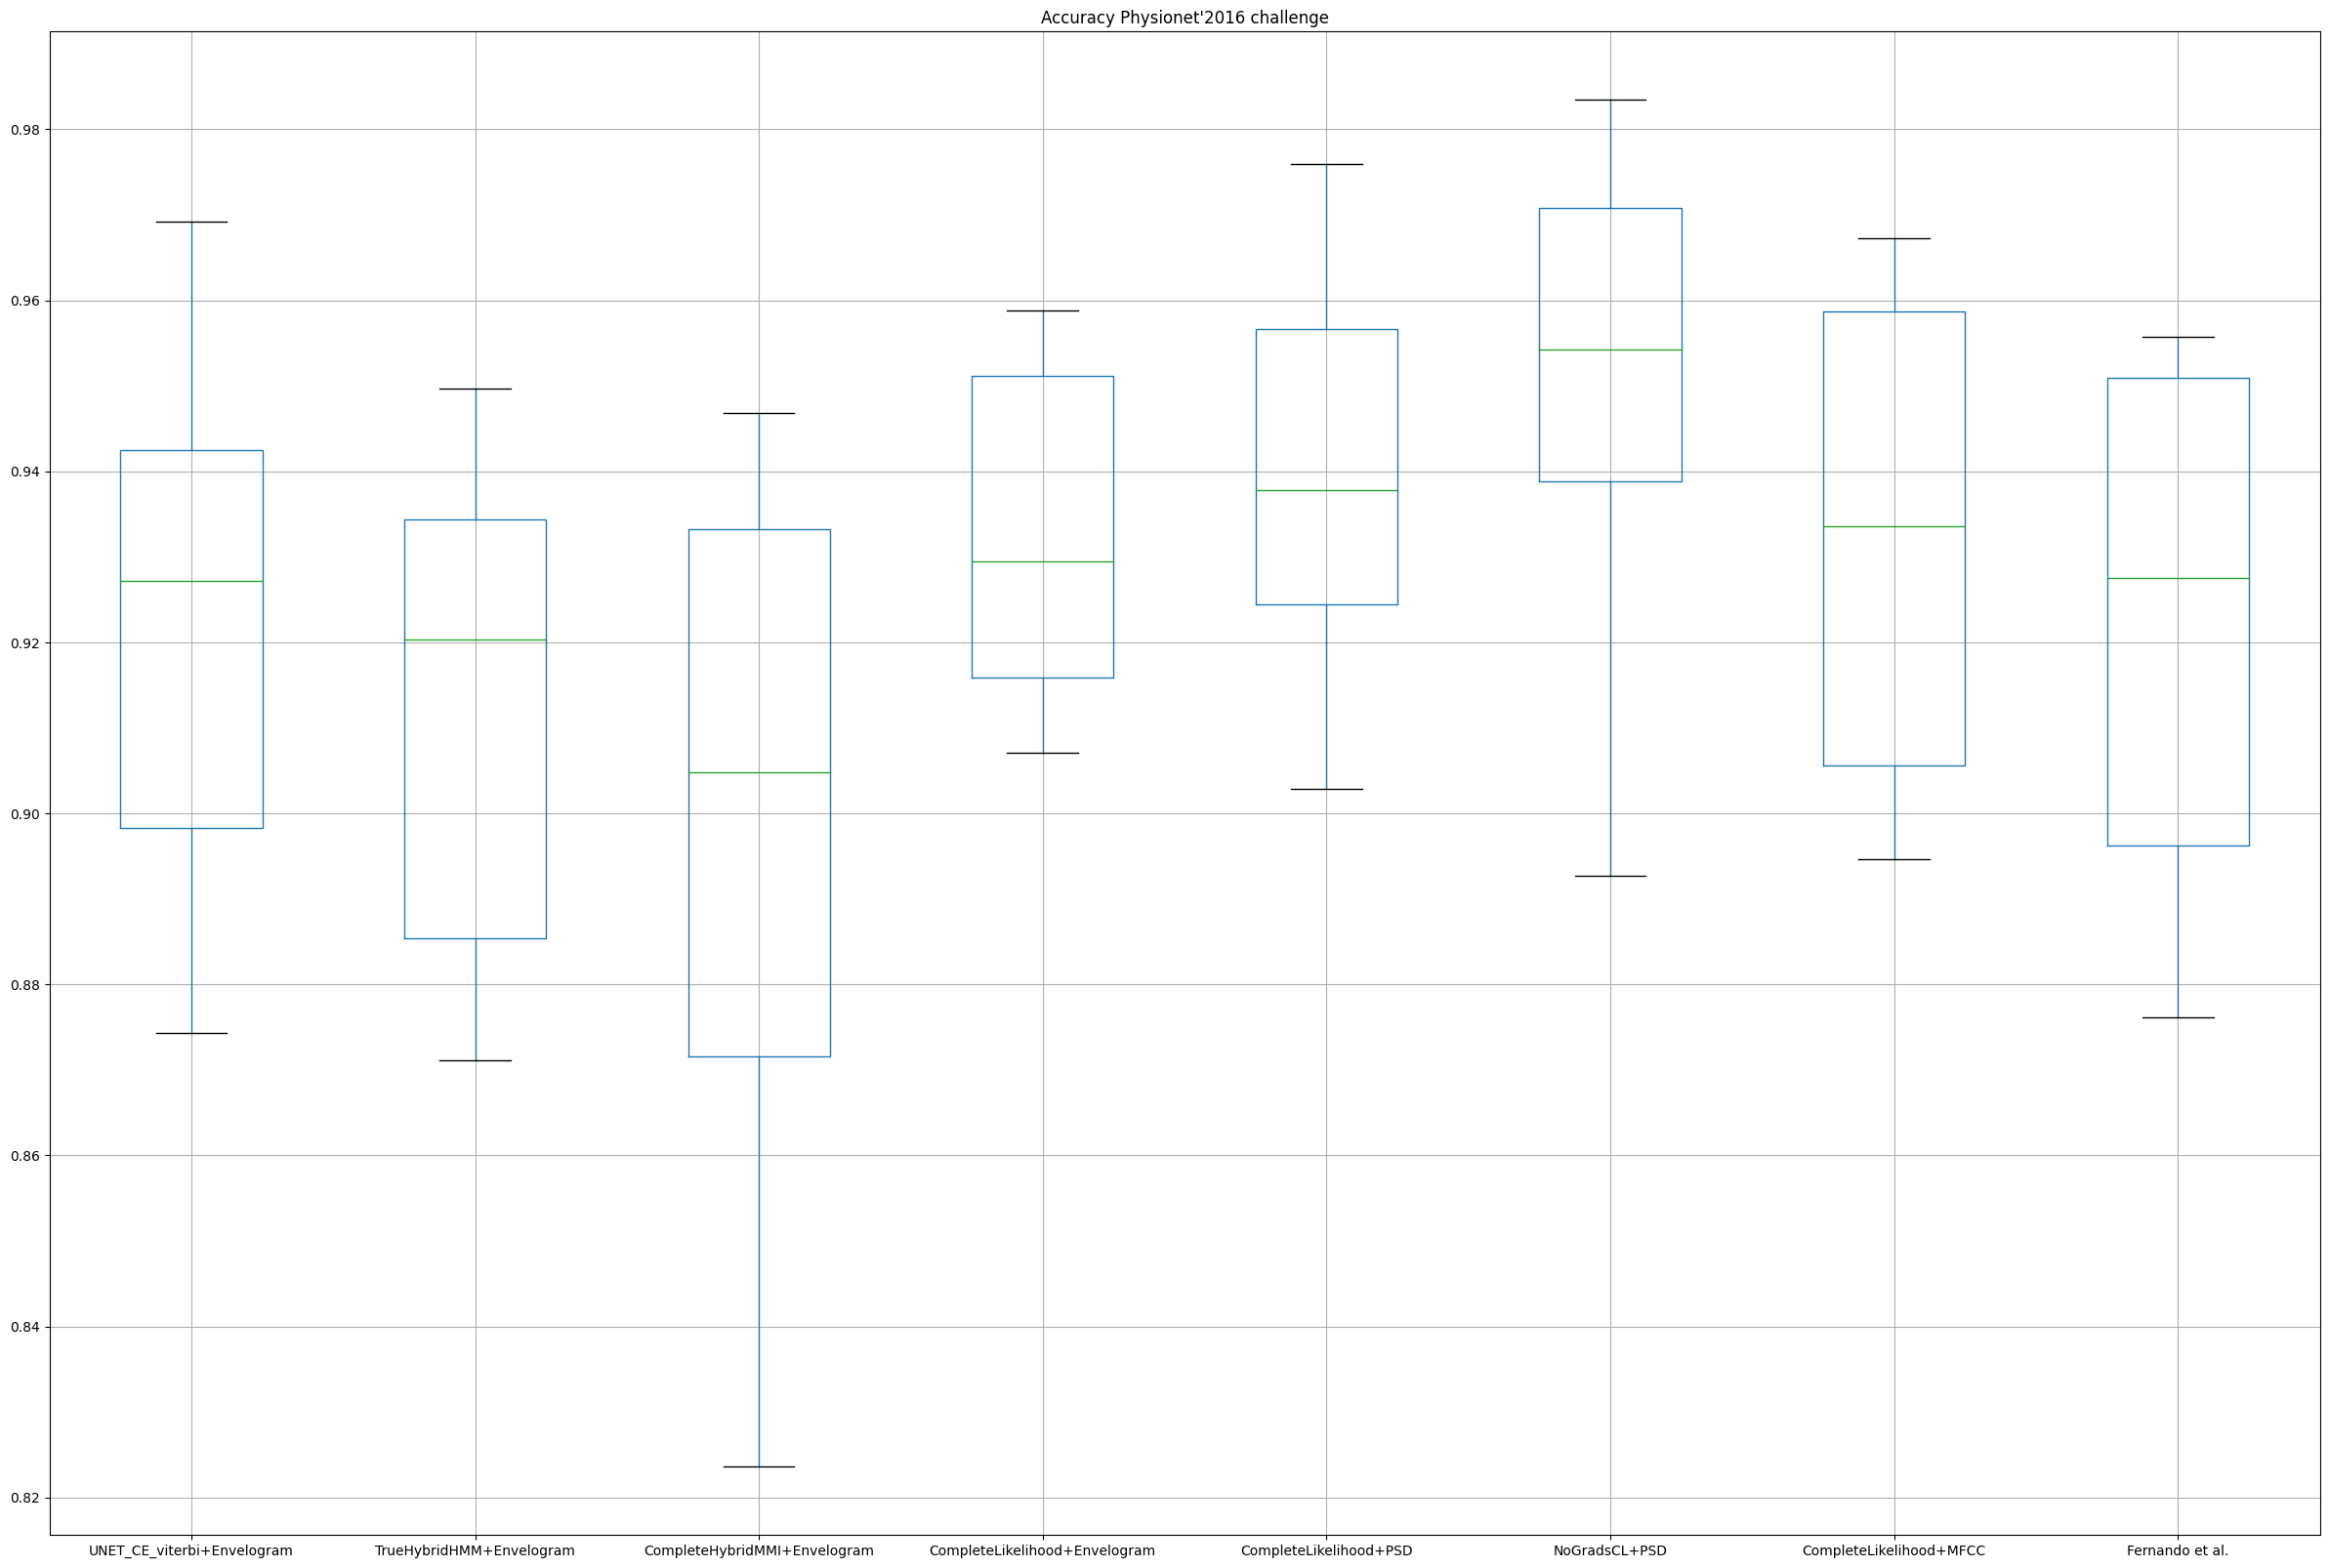

In [34]:
df = pd.DataFrame({'UNET_CE_viterbi+Envelogram': ph16_crosse_unet_env[2],
                   'TrueHybridHMM+Envelogram': ph16_true_hybrid_cnn_env[2],
                   'CompleteHybridMMI+Envelogram': ph16_completemmi_hybrid_cnn_env[2],
                   'CompleteLikelihood+Envelogram':ph16_completelikelihood_hybrid_cnn_env[2],
                   # 'NoGradsCL+Envelogram': ph16_completelikelihood_nograds_cnn_env[0], 
                   'CompleteLikelihood+PSD': ph16_completelikelihood_hybrid_cnn_psd[2],
                   'NoGradsCL+PSD': ph16_completelikelihood_cnngrads_psd[2],
                   'CompleteLikelihood+MFCC': ph16_completelikelihood_hybrid_cnn_mfcc[2],
                   'Fernando et al.': ph16_fernado_mfcc_joint[2],
                   }) # no grads CL, no grads MMI,  CL envelogram, corrected fernando
    
# fine tune best HMM
# transfer u-net, fernando and springer

boxplot = df.boxplot(column=list(df.keys()), figsize=(30,20))
plt.title('Accuracy Physionet\'2016 challenge')
plt.show()

In [35]:
df = pd.DataFrame({'UNET_CE_viterbi+Envelogram': ph16_crosse_unet_env[2],
                   'HybridGradients+Envelogram': ph16_hybrid_cnn_env[2],
                   'HybridGradients+PSD': ph16_hybrid_cnn_psd[2],
                   'TrueHybridHMM+Envelogram': ph16_true_hybrid_cnn_env[2],
                   'CompleteHybridMMI+Envelogram': ph16_completemmi_hybrid_cnn_env[2],
                   'CompleteLikelihood+Envelogram':ph16_completelikelihood_hybrid_cnn_env[2],
                   'NoGradsCL+Envelogram': ph16_completelikelihood_nograds_cnn_env[2], 
                   'CompleteLikelihood+PSD': ph16_completelikelihood_hybrid_cnn_psd[2],
                   'NoGradsCL+PSD': ph16_completelikelihood_cnngrads_psd[2],
                   'FtHMMCL+PSD20': ph16_psd_fine_tune_hmm20[2],
                   'CompleteLikelihood+MFCC': ph16_completelikelihood_hybrid_cnn_mfcc[2],
                   'Fernando et al.': ph16_fernado_mfcc_joint[1],
                   })

boxplot = df.boxplot(column=list(df.keys()), figsize=(30,20))
plt.title('Sensitivity Physionet\'2016 challenge')
plt.show()

NameError: name 'ph16_completelikelihood_nograds_cnn_env' is not defined

In [ ]:
!ls results/hybrid/hmm_completlikelihood1e3_physio16_envelops_joint/2022-03-20_12:55:33

In [ ]:
!ls results/unet/unet/2022-02-26_07:49:39

In [ ]:
ph16_psd_fine_tune[0]

In [ ]:
ph16_psd_fine_tune2[0]

In [ ]:
ph16_psd_ft_hmm_cnn[2]

In [ ]:
np.sum(ph16_psd_ft_hmm_cnn[1]) / 8

In [ ]:
[1, 2, 3, 4] + [5]

In [ ]:
df = pd.DataFrame({'UNET_CE_viterbi+Envelogram': ph16_crosse_unet_env[1],
                   'HybridGradients+Envelogram': ph16_hybrid_cnn_env[1],
                   'HybridGradients+PSD': ph16_hybrid_cnn_psd[1],
                   'TrueHybridHMM+Envelogram': ph16_true_hybrid_cnn_env[1],
                   'CompleteHybridMMI+Envelogram': ph16_completemmi_hybrid_cnn_env[1],
                   'CompleteLikelihood+Envelogram':ph16_completelikelihood_hybrid_cnn_env[1],
                   'NoGradsCL+Envelogram': ph16_completelikelihood_nograds_cnn_env[1], 
                   'CompleteLikelihood+PSD': ph16_completelikelihood_hybrid_cnn_psd[1],
                   'NoGradsCL+PSD': ph16_completelikelihood_cnngrads_psd[1],
                   'FtHMMCL+PSD20': ph16_psd_fine_tune_hmm20[1],
                   'CompleteLikelihood+MFCC': ph16_completelikelihood_hybrid_cnn_mfcc[1],
                   'NoGradsCL+PSD': ph16_completelikelihood_nograds_cnn_psd[1], 
                   'Fernando et al.': ph16_fernado_mfcc_joint[1],
                   })

boxplot = df.boxplot(column=list(df.keys()), figsize=(30,20))
plt.title('PPV Physionet\'2016 challenge')
plt.show()

In [116]:
!ls results/rerun/circor/hmm_range_1_100_finetune_pretained_ph16_circor20/2022-10-07_16_31_41


results.hdf5


In [149]:
import h5py
import re

In [119]:
f = h5py.File('results/rerun/circor/hmm_range_1_100_finetune_pretained_ph16_circor20/2022-10-07_16_31_41/results.hdf5', 'r')

In [177]:
attributes_fold = list(f['fold0/data/'].attrs.keys())

In [161]:
sorted(gt_fold, key=lambda x: int(re.search('\d+',x).group()))

['gt_0',
 'gt_1',
 'gt_2',
 'gt_3',
 'gt_4',
 'gt_5',
 'gt_6',
 'gt_7',
 'gt_8',
 'gt_9',
 'gt_10',
 'gt_11',
 'gt_12',
 'gt_13',
 'gt_14',
 'gt_15',
 'gt_16',
 'gt_17',
 'gt_18',
 'gt_19',
 'gt_20',
 'gt_21',
 'gt_22',
 'gt_23',
 'gt_24',
 'gt_25',
 'gt_26',
 'gt_27',
 'gt_28',
 'gt_29',
 'gt_30',
 'gt_31',
 'gt_32',
 'gt_33',
 'gt_34',
 'gt_35',
 'gt_36',
 'gt_37',
 'gt_38',
 'gt_39',
 'gt_40',
 'gt_41',
 'gt_42',
 'gt_43',
 'gt_44',
 'gt_45',
 'gt_46',
 'gt_47',
 'gt_48',
 'gt_49',
 'gt_50',
 'gt_51',
 'gt_52',
 'gt_53',
 'gt_54',
 'gt_55',
 'gt_56',
 'gt_57',
 'gt_58',
 'gt_59',
 'gt_60',
 'gt_61',
 'gt_62',
 'gt_63',
 'gt_64',
 'gt_65',
 'gt_66',
 'gt_67',
 'gt_68',
 'gt_69',
 'gt_70',
 'gt_71',
 'gt_72',
 'gt_73',
 'gt_74',
 'gt_75',
 'gt_76',
 'gt_77',
 'gt_78',
 'gt_79',
 'gt_80',
 'gt_81',
 'gt_82',
 'gt_83',
 'gt_84',
 'gt_85',
 'gt_86',
 'gt_87',
 'gt_88',
 'gt_89',
 'gt_90',
 'gt_91',
 'gt_92',
 'gt_93',
 'gt_94',
 'gt_95',
 'gt_96',
 'gt_97',
 'gt_98',
 'gt_99',
 'gt_100',

In [200]:




preds_fold

['preds0_0',
 'preds0_1',
 'preds0_2',
 'preds0_3',
 'preds0_4',
 'preds0_5',
 'preds0_6',
 'preds0_7',
 'preds0_8',
 'preds0_9',
 'preds0_10',
 'preds0_11',
 'preds0_12',
 'preds0_13',
 'preds0_14',
 'preds0_15',
 'preds0_16',
 'preds0_17',
 'preds0_18',
 'preds0_19',
 'preds0_20',
 'preds0_21',
 'preds0_22',
 'preds0_23',
 'preds0_24',
 'preds0_25',
 'preds0_26',
 'preds0_27',
 'preds0_28',
 'preds0_29',
 'preds0_30',
 'preds0_31',
 'preds0_32',
 'preds0_33',
 'preds0_34',
 'preds0_35',
 'preds0_36',
 'preds0_37',
 'preds0_38',
 'preds0_39',
 'preds0_40',
 'preds0_41',
 'preds0_42',
 'preds0_43',
 'preds0_44',
 'preds0_45',
 'preds0_46',
 'preds0_47',
 'preds0_48',
 'preds0_49',
 'preds1_0',
 'preds1_1',
 'preds1_2',
 'preds1_3',
 'preds1_4',
 'preds1_5',
 'preds1_6',
 'preds1_7',
 'preds1_8',
 'preds1_9',
 'preds1_10',
 'preds1_11',
 'preds1_12',
 'preds1_13',
 'preds1_14',
 'preds1_15',
 'preds1_16',
 'preds1_17',
 'preds1_18',
 'preds1_19',
 'preds1_20',
 'preds1_21',
 'preds1_22'

In [191]:
p = [x for x in preds_fold  if int(re.findall('\d+', x)[-1]) == 10]
p

['preds0_10',
 'preds100_10',
 'preds101_10',
 'preds102_10',
 'preds103_10',
 'preds104_10',
 'preds105_10',
 'preds106_10',
 'preds107_10',
 'preds108_10',
 'preds109_10',
 'preds10_10',
 'preds110_10',
 'preds111_10',
 'preds112_10',
 'preds113_10',
 'preds114_10',
 'preds115_10',
 'preds116_10',
 'preds117_10',
 'preds118_10',
 'preds119_10',
 'preds11_10',
 'preds120_10',
 'preds121_10',
 'preds122_10',
 'preds123_10',
 'preds124_10',
 'preds125_10',
 'preds126_10',
 'preds127_10',
 'preds128_10',
 'preds129_10',
 'preds12_10',
 'preds130_10',
 'preds131_10',
 'preds132_10',
 'preds133_10',
 'preds134_10',
 'preds135_10',
 'preds136_10',
 'preds137_10',
 'preds138_10',
 'preds139_10',
 'preds13_10',
 'preds140_10',
 'preds141_10',
 'preds142_10',
 'preds143_10',
 'preds144_10',
 'preds145_10',
 'preds146_10',
 'preds147_10',
 'preds148_10',
 'preds149_10',
 'preds14_10',
 'preds150_10',
 'preds151_10',
 'preds152_10',
 'preds153_10',
 'preds154_10',
 'preds155_10',
 'preds156_10',

In [209]:
f['/fold0/data/'].attrs['gt_0']

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,

In [215]:
f['/fold0/data/'].attrs['preds0_10'], f['/fold0/data/'].attrs['preds0_40']

(array([1, 1, 1, 1, 1, 1, 1, 2, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 2, 3, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2,
        2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

In [180]:
re.findall('\d+', 'preds200_10')[-1]

'10'

In [308]:
def get_attribute_names(fold_ptr, fold):
    attributes_fold = list(fold_ptr.attrs.keys())
    gt_fold = [x for x in attributes_fold if x.startswith('gt')]
    preds_fold = [x for x in attributes_fold if x.startswith('preds')]
    gt_fold = sorted(gt_fold, key=lambda x: int(re.search('\d+',x).group()))
    preds_fold = sorted(preds_fold, key=lambda x: 
                        (50 * int(re.findall('\d+', x)[0])) + int(re.findall('\d+', x)[-1]))
    return gt_fold, preds_fold

def process_hdf5(filename, number_folds=10, nreps=50):
    f = h5py.File(filename, 'r')
    fold_ppv, fold_sens = [], []
    for fold in range(number_folds):
        fold_data = f[f'fold{fold}/data/']
        gts, preds = get_attribute_names(fold_data, fold)
        obs_ppv, obs_sens = [], []
        for idx, gt_name in enumerate(gts):
            start = idx * nreps
            print(start)
            continue
            ft_ppv, ft_sens = [], []
            gt = fold_data.attrs[gt_name]
            for i in range(nreps):
                pred = fold_data.attrs[preds[start + i]]
                ppv_, sensitivity_ = schmidt_metrics(gt, pred)
                ft_ppv.append(ppv_)
                ft_sens.append(sensitivity_)
            obs_ppv.append(ft_ppv)
            obs_sens.append(ft_sens)
        fold_ppv.append(obs_ppv)
        fold_sens.append(obs_sens)
    return fold_ppv, fold_sens

In [256]:
directory = 'results/rerun/circor/hmm_range_1_100_finetune_pretained_ph16_circor20/2022-10-07_16_31_41/results.hdf5'
ppv, sens = process_hdf5(directory, number_folds=10, nreps=50)

In [264]:
ppv, sens = np.array(ppv), np.array(sens)

In [309]:
process_hdf5(directory, number_folds=10, nreps=50)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
5000
5050
5100
5150
5200
5250
5300
5350
5400
5450
5500
5550
5600
5650
5700
5750
5800
5850
5900
5950
6000
6050
6100
6150
6200
6250
6300
6350
6400
6450
6500
6550
6600
6650
6700
6750
6800
6850
6900
6950
7000
7050
7100
7150
7200
7250
7300
7350
7400
7450
7500
7550
7600
7650
7700
7750
7800
7850
7900
7950
8000
8050
8100
8150
8200
8250
8300
8350
8400
8450
8500
8550
8600
8650
8700
8750
8800
8850
8900
8950
9000
9050
9100
9150
9200
9250
9300
9350
9400
9450
9500
9550
9600
9650
9700
9750
9800
9850
9900
9950
10000
10050
10100
10150

15650
15700
15750
15800
15850
15900
15950
16000
16050
16100
16150
16200
16250
16300
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
5000
5050
5100
5150
5200
5250
5300
5350
5400
5450
5500
5550
5600
5650
5700
5750
5800
5850
5900
5950
6000
6050
6100
6150
6200
6250
6300
6350
6400
6450
6500
6550
6600
6650
6700
6750
6800
6850
6900
6950
7000
7050
7100
7150
7200
7250
7300
7350
7400
7450
7500
7550
7600
7650
7700
7750
7800
7850
7900
7950
8000
8050
8100
8150
8200
8250
8300
8350
8400
8450
8500
8550
8600
8650
8700
8750
8800
8850
8900
8950
9000
9050
9100
9150
9200
9250
9300
9350

([[], [], [], [], [], [], [], [], [], []],
 [[], [], [], [], [], [], [], [], [], []])

In [310]:
ppv.shape

(10, 327, 50)

In [311]:
327 * 50

16350

In [305]:
def plot_fine_tune(results, num_epochs=50):
    y = np.mean(np.mean(results, axis=1), axis=0)
    y_error = np.std(np.mean(results, axis=1), axis=0)
    x = [i for i in range(num_epochs)]
    plt.scatter(x, y)
    plt.errorbar(x, y, yerr = y_error,fmt='o',ecolor = 'red',color='black')
    plt.show()

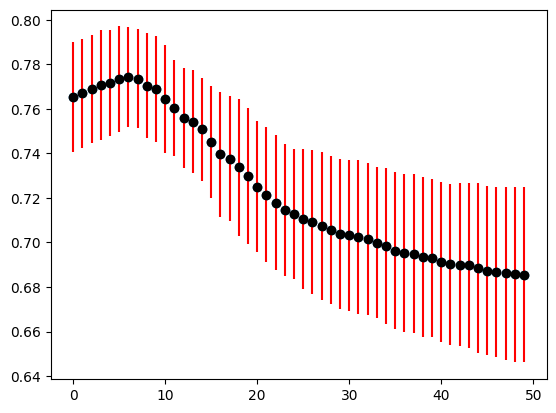

In [306]:
plot_fine_tune(ppv)

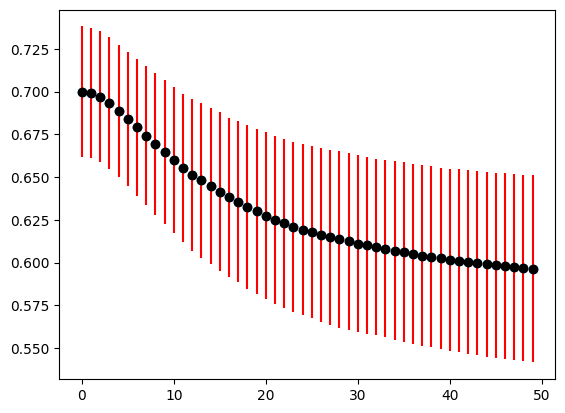

In [307]:
plot_fine_tune(sens)

In [324]:
np.mean(np.mean(sens, axis=1), axis=0)

array([0.70006054, 0.6992411 , 0.69713755, 0.69336292, 0.68870882,
       0.68401283, 0.6790787 , 0.67435026, 0.6694116 , 0.66469924,
       0.65988779, 0.6555407 , 0.65139472, 0.64821429, 0.64485739,
       0.64150486, 0.63812001, 0.63565215, 0.6325063 , 0.6299355 ,
       0.62746259, 0.6248488 , 0.62288626, 0.62086542, 0.61928801,
       0.61775147, 0.61632898, 0.61477902, 0.61359871, 0.61235574,
       0.61117668, 0.61007862, 0.60912178, 0.6081745 , 0.6069875 ,
       0.60594358, 0.60498061, 0.60409057, 0.60343061, 0.60245313,
       0.60181047, 0.60103054, 0.60051163, 0.59973686, 0.5989413 ,
       0.59835576, 0.59797223, 0.59744431, 0.59684168, 0.59637917])